In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3'
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizerFast

import utils
from dataset import MBTIDataset, MBTIBatchSampler, mbti_collate_fn
from bertviz.bertviz import head_view

from tqdm import tqdm, trange

In [2]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [3]:
def train(model, train_loader, val_loader, optimizer, tokenizer):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    loss_log = tqdm(total=0, bar_format='{desc}', position=3)
    acc_log = tqdm(total=0, bar_format='{desc}', position=4)

    for epoch in trange(epochs, desc="Epoch"):
        train_loss, train_acc = [], []
        model.train()
        for posts, attention_mask, labels in tqdm(train_loader, desc="Training Iteration"):
            posts = posts.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            loss, logits, _ = model(posts, attention_mask=attention_mask, labels=labels)                       
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            # scheduler.step()

            preds = torch.argmax(logits.data, dim=1)
            acc = (preds == labels).sum().item() / len(labels)

            train_loss.append(loss.item())
            train_acc.append(acc)

            des1 = 'Training Loss: {:06.4f}'.format(loss.cpu())
            des2 = 'Training Acc: {:.0%}'.format(acc)
            loss_log.set_description_str(des1)
            acc_log.set_description_str(des2)
            del loss
        
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        print()
        print("Average Training Loss:", avg_train_loss)
        print("Average Training Acc:", avg_train_acc)
        print()
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
    
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for posts, attention_mask, labels in tqdm(val_loader, desc="Validation Iteration"):
                posts = posts.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
                input_id_list = posts[0].tolist()   # batch index 0 (need it for vis later)

                loss, logits, attentions = model(posts, attention_mask=attention_mask, labels=labels)        
                loss = loss.mean()
                pred = torch.argmax(logits.data, dim=1)
                acc = (pred == labels).sum().item() / len(labels)
                
                val_loss.append(loss.item())
                val_acc.append(acc)

                des1 = 'Validation Loss: {:06.4f}'.format(loss.cpu())
                des2 = 'Validation Acc: {:.0%}'.format(acc)
                loss_log.set_description_str(des1)
                acc_log.set_description_str(des2)
                del loss
        
        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print()
        print("Average Validation Loss:", avg_val_loss)
        print("Average Validation Acc:", avg_val_acc)
        print()
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
    
    # attentions and tokens for visualizing last layer's attention
    attentions = [att[0].unsqueeze(0) for att in attentions]    # batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    
    return train_losses, val_losses, train_accuracies, val_accuracies, attentions, tokens

In [4]:
# Tune hyperparameters here
batch_size = 8          # 16 or 32          (recommended in BERT paper)
epochs = 4              # 2, 3, or 4        
learning_rate = 5e-5    # 5e-5, 3e-5, 2e-5
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

Running on: cuda


In [5]:
# Load pretrained BERT model
model_name = "16classes_per_person_bert_vis"
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16, output_attentions=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

In [6]:
# Load & store data into memory    
train_set = MBTIDataset('./preprocess_mine/per_person_for_bert/mbti_train.tsv', tokenizer)
val_set = MBTIDataset('./preprocess_mine/per_person_for_bert/mbti_val.tsv', tokenizer)

train_batch_sampler = MBTIBatchSampler(train_set, batch_size=batch_size, shuffle=True)
val_batch_sampler = MBTIBatchSampler(val_set, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_set, batch_sampler=train_batch_sampler, collate_fn=mbti_collate_fn)
val_loader = DataLoader(val_set, batch_sampler=val_batch_sampler, collate_fn=mbti_collate_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader), num_training_steps=len(train_loader)*epochs)

Reading ./preprocess_mine/per_person_for_bert/mbti_train.tsv: 6940it [00:42, 163.67it/s]
Reading ./preprocess_mine/per_person_for_bert/mbti_val.tsv: 1735it [00:10, 161.24it/s]
Bucketing: 100%|██████████| 1735/1735 [00:00<00:00, 1023936.60it/s]


In [7]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, attentions, tokens = train(model, train_loader, val_loader, optimizer, tokenizer)
# torch.save(model.state_dict(), model_name+'.pth')








Training Iteration:   0%|          | 0/868 [00:00<?, ?it/s]/home/nas1_userA/minseokchoi20/anaconda3/envs/nlp-project/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Training Loss: 3.0826



Training Acc: 0%
Training Iteration:   0%|          | 1/868 [00:08<2:03:07,  8.52s/it]


Training Loss: 2.6574



Training Acc: 38%
Training Iteration:   0%|          | 2/868 [00:08<1:28:01,  6.10s/it]


Training Loss: 2.5175



Training Acc: 25%
Training Iteration:   0%|          | 3/868 [00:09<1:03:27,  4.40s/it]


Training Loss: 2.5598



Training Acc: 25%
Training Iteration:   0%|          | 4/868 [00:09<46:15,  3.21s/it]  


Training Loss: 2.5708



Training Acc: 25%
Training Iteration:   1%|          | 5/868 [00:10<34:38,  2.41s/it]


Training Loss: 2.5438



Training Acc: 

Training Loss: 2.4795



Training Acc: 12%
Training Iteration:   7%|▋         | 57/868 [00:33<06:05,  2.22it/s]


Training Loss: 2.8015



Training Acc: 0% 
Training Iteration:   7%|▋         | 58/868 [00:33<06:04,  2.22it/s]


Training Loss: 2.3672



Training Acc: 12%
Training Iteration:   7%|▋         | 59/868 [00:34<05:56,  2.27it/s]


Training Loss: 2.5773



Training Acc: 25%
Training Iteration:   7%|▋         | 60/868 [00:34<05:58,  2.25it/s]


Training Loss: 2.8278



Training Acc: 0% 
Training Iteration:   7%|▋         | 61/868 [00:35<05:53,  2.28it/s]


Training Loss: 1.9823



Training Acc: 12%
Training Iteration:   7%|▋         | 62/868 [00:35<05:49,  2.30it/s]


Training Loss: 2.0931



Training Acc: 25%
Training Iteration:   7%|▋         | 63/868 [00:36<05:50,  2.30it/s]


Training Loss: 2.5573



Training Acc: 0% 
Training Iteration:   7%|▋         | 64/868 [00:36<05:47,  2.31it/s]


Training Loss: 2.1718



Training Acc: 12%
Training Iteration:   7%|▋         | 65/868 [

Training Acc: 25%
Training Iteration:  13%|█▎        | 116/868 [00:59<05:33,  2.26it/s]


Training Loss: 1.9498



Training Acc: 12%
Training Iteration:  13%|█▎        | 117/868 [00:59<05:33,  2.25it/s]


Training Loss: 2.5552



Training Acc: 0% 
Training Iteration:  14%|█▎        | 118/868 [01:00<05:32,  2.25it/s]


Training Loss: 2.1719



Training Acc: 12%
Training Iteration:  14%|█▎        | 119/868 [01:00<05:31,  2.26it/s]


Training Loss: 2.6831



Training Acc: 12%
Training Iteration:  14%|█▍        | 120/868 [01:01<05:32,  2.25it/s]


Training Loss: 2.0584



Training Acc: 25%
Training Iteration:  14%|█▍        | 121/868 [01:01<05:37,  2.21it/s]


Training Loss: 2.0687



Training Acc: 50%
Training Iteration:  14%|█▍        | 122/868 [01:02<05:34,  2.23it/s]


Training Loss: 2.2571



Training Acc: 25%
Training Iteration:  14%|█▍        | 123/868 [01:02<05:29,  2.26it/s]


Training Loss: 2.8767



Training Acc: 12%
Training Iteration:  14%|█▍        | 124/868 [01:03<05:30,  2.

Training Loss: 2.4785



Training Acc: 12%
Training Iteration:  20%|██        | 175/868 [01:25<05:11,  2.23it/s]


Training Loss: 2.4231



Training Acc: 25%
Training Iteration:  20%|██        | 176/868 [01:26<05:09,  2.23it/s]


Training Loss: 2.5161



Training Acc: 0% 
Training Iteration:  20%|██        | 177/868 [01:26<05:08,  2.24it/s]


Training Loss: 2.4460



Training Acc: 12%
Training Iteration:  21%|██        | 178/868 [01:27<05:08,  2.24it/s]


Training Loss: 2.4246



Training Acc: 25%
Training Iteration:  21%|██        | 179/868 [01:27<05:08,  2.24it/s]


Training Loss: 2.5134



Training Acc: 12%
Training Iteration:  21%|██        | 180/868 [01:28<05:07,  2.23it/s]


Training Loss: 2.2632



Training Acc: 12%
Training Iteration:  21%|██        | 181/868 [01:28<05:05,  2.25it/s]


Training Loss: 2.4885



Training Acc: 0% 
Training Iteration:  21%|██        | 182/868 [01:28<05:00,  2.28it/s]


Training Loss: 2.1579



Training Acc: 12%
Training Iteration:  21%|██        | 

Training Iteration:  27%|██▋       | 233/868 [01:51<04:41,  2.26it/s]


Training Loss: 2.2769



Training Acc: 12%
Training Iteration:  27%|██▋       | 234/868 [01:51<04:37,  2.29it/s]


Training Loss: 1.9470



Training Acc: 38%
Training Iteration:  27%|██▋       | 235/868 [01:52<04:39,  2.27it/s]


Training Loss: 2.2605



Training Acc: 25%
Training Iteration:  27%|██▋       | 236/868 [01:52<04:50,  2.17it/s]


Training Loss: 2.3184



Training Acc: 25%
Training Iteration:  27%|██▋       | 237/868 [01:53<04:43,  2.22it/s]


Training Loss: 2.6372



Training Acc: 0% 
Training Iteration:  27%|██▋       | 238/868 [01:53<04:42,  2.23it/s]


Training Loss: 2.4977



Training Acc: 0%
Training Iteration:  28%|██▊       | 239/868 [01:54<04:39,  2.25it/s]


Training Loss: 2.1979



Training Acc: 38%
Training Iteration:  28%|██▊       | 240/868 [01:54<04:35,  2.28it/s]


Training Loss: 2.5178



Training Acc: 12%
Training Iteration:  28%|██▊       | 241/868 [01:54<04:36,  2.27it/s]


Training 

Training Acc: 25%
Training Iteration:  34%|███▎      | 292/868 [02:17<04:13,  2.27it/s]


Training Loss: 2.1680



Training Acc: 0% 
Training Iteration:  34%|███▍      | 293/868 [02:17<04:15,  2.25it/s]


Training Loss: 2.2817



Training Acc: 12%
Training Iteration:  34%|███▍      | 294/868 [02:18<04:12,  2.27it/s]


Training Loss: 2.4888



Training Acc: 0% 
Training Iteration:  34%|███▍      | 295/868 [02:18<04:13,  2.26it/s]


Training Loss: 2.2418



Training Acc: 25%
Training Iteration:  34%|███▍      | 296/868 [02:19<04:11,  2.27it/s]


Training Loss: 2.3388



Training Acc: 0% 
Training Iteration:  34%|███▍      | 297/868 [02:19<04:10,  2.28it/s]


Training Loss: 2.4121



Training Acc: 38%
Training Iteration:  34%|███▍      | 298/868 [02:20<04:11,  2.26it/s]


Training Loss: 2.6230



Training Acc: 25%
Training Iteration:  34%|███▍      | 299/868 [02:20<04:09,  2.28it/s]


Training Loss: 2.2937



Training Acc: 12%
Training Iteration:  35%|███▍      | 300/868 [02:20<04:08,  2.

Training Loss: 1.8971



Training Acc: 12%
Training Iteration:  40%|████      | 351/868 [02:43<03:49,  2.25it/s]


Training Loss: 2.0593



Training Acc: 12%
Training Iteration:  41%|████      | 352/868 [02:44<03:53,  2.21it/s]


Training Loss: 2.5054



Training Acc: 25%
Training Iteration:  41%|████      | 353/868 [02:44<03:52,  2.21it/s]


Training Loss: 2.6260



Training Acc: 25%
Training Iteration:  41%|████      | 354/868 [02:45<03:47,  2.25it/s]


Training Loss: 2.0385



Training Acc: 25%
Training Iteration:  41%|████      | 355/868 [02:45<03:47,  2.26it/s]


Training Loss: 2.3702



Training Acc: 12%
Training Iteration:  41%|████      | 356/868 [02:45<03:45,  2.27it/s]


Training Loss: 2.0903



Training Acc: 12%
Training Iteration:  41%|████      | 357/868 [02:46<03:46,  2.25it/s]


Training Loss: 2.6279



Training Acc: 12%
Training Iteration:  41%|████      | 358/868 [02:46<03:46,  2.25it/s]


Training Loss: 2.3121



Training Acc: 12%
Training Iteration:  41%|████▏     | 

Training Iteration:  47%|████▋     | 409/868 [03:09<03:20,  2.29it/s]


Training Loss: 2.8671



Training Acc: 12%
Training Iteration:  47%|████▋     | 410/868 [03:09<03:22,  2.27it/s]


Training Loss: 2.5622



Training Acc: 25%
Training Iteration:  47%|████▋     | 411/868 [03:10<03:22,  2.26it/s]


Training Loss: 2.3250



Training Acc: 12%
Training Iteration:  47%|████▋     | 412/868 [03:10<03:21,  2.26it/s]


Training Loss: 2.4697



Training Acc: 12%
Training Iteration:  48%|████▊     | 413/868 [03:11<03:21,  2.25it/s]


Training Loss: 2.0707



Training Acc: 12%
Training Iteration:  48%|████▊     | 414/868 [03:11<03:18,  2.28it/s]


Training Loss: 1.9781



Training Acc: 38%
Training Iteration:  48%|████▊     | 415/868 [03:12<03:19,  2.27it/s]


Training Loss: 2.0985



Training Acc: 38%
Training Iteration:  48%|████▊     | 416/868 [03:12<03:19,  2.26it/s]


Training Loss: 2.3539



Training Acc: 12%
Training Iteration:  48%|████▊     | 417/868 [03:12<03:17,  2.28it/s]


Training

Training Acc: 12%
Training Iteration:  54%|█████▍    | 468/868 [03:35<03:04,  2.17it/s]


Training Loss: 2.3207



Training Acc: 25%
Training Iteration:  54%|█████▍    | 469/868 [03:35<03:00,  2.21it/s]


Training Loss: 2.6982



Training Acc: 25%
Training Iteration:  54%|█████▍    | 470/868 [03:36<02:59,  2.21it/s]


Training Loss: 2.1742



Training Acc: 0% 
Training Iteration:  54%|█████▍    | 471/868 [03:36<02:59,  2.22it/s]


Training Loss: 2.6797



Training Acc: 0%
Training Iteration:  54%|█████▍    | 472/868 [03:37<02:55,  2.25it/s]


Training Loss: 2.0836



Training Acc: 25%
Training Iteration:  54%|█████▍    | 473/868 [03:37<02:55,  2.25it/s]


Training Loss: 2.5754



Training Acc: 12%
Training Iteration:  55%|█████▍    | 474/868 [03:38<02:54,  2.25it/s]


Training Loss: 2.2655



Training Acc: 12%
Training Iteration:  55%|█████▍    | 475/868 [03:38<02:54,  2.25it/s]


Training Loss: 2.1684



Training Acc: 12%
Training Iteration:  55%|█████▍    | 476/868 [03:39<02:53,  2.2

Training Loss: 2.3459



Training Acc: 12%
Training Iteration:  61%|██████    | 527/868 [04:01<02:32,  2.24it/s]


Training Loss: 2.4202



Training Acc: 12%
Training Iteration:  61%|██████    | 528/868 [04:02<02:31,  2.25it/s]


Training Loss: 2.9876



Training Acc: 0% 
Training Iteration:  61%|██████    | 529/868 [04:02<02:29,  2.27it/s]


Training Loss: 2.5265



Training Acc: 0%
Training Iteration:  61%|██████    | 530/868 [04:02<02:27,  2.30it/s]


Training Loss: 2.0878



Training Acc: 50%
Training Iteration:  61%|██████    | 531/868 [04:03<02:27,  2.28it/s]


Training Loss: 2.0914



Training Acc: 38%
Training Iteration:  61%|██████▏   | 532/868 [04:03<02:26,  2.30it/s]


Training Loss: 2.3631



Training Acc: 12%
Training Iteration:  61%|██████▏   | 533/868 [04:04<02:36,  2.14it/s]


Training Loss: 1.9514



Training Acc: 25%
Training Iteration:  62%|██████▏   | 534/868 [04:04<02:34,  2.17it/s]


Training Loss: 2.0666



Training Acc: 25%
Training Iteration:  62%|██████▏   | 5

Training Iteration:  67%|██████▋   | 585/868 [04:27<02:07,  2.22it/s]


Training Loss: 2.2271



Training Acc: 25%
Training Iteration:  68%|██████▊   | 586/868 [04:28<02:06,  2.22it/s]


Training Loss: 2.3875



Training Acc: 12%
Training Iteration:  68%|██████▊   | 587/868 [04:28<02:06,  2.22it/s]


Training Loss: 2.2584



Training Acc: 38%
Training Iteration:  68%|██████▊   | 588/868 [04:28<02:06,  2.22it/s]


Training Loss: 2.3030



Training Acc: 0% 
Training Iteration:  68%|██████▊   | 589/868 [04:29<02:04,  2.24it/s]


Training Loss: 2.1029



Training Acc: 25%
Training Iteration:  68%|██████▊   | 590/868 [04:29<02:04,  2.23it/s]


Training Loss: 2.2834



Training Acc: 25%
Training Iteration:  68%|██████▊   | 591/868 [04:30<02:03,  2.25it/s]


Training Loss: 2.1447



Training Acc: 25%
Training Iteration:  68%|██████▊   | 592/868 [04:30<02:03,  2.23it/s]


Training Loss: 2.5504



Training Acc: 12%
Training Iteration:  68%|██████▊   | 593/868 [04:31<02:02,  2.24it/s]


Training

Training Acc: 25%
Training Iteration:  74%|███████▍  | 644/868 [04:53<01:36,  2.31it/s]


Training Loss: 1.7964



Training Acc: 38%
Training Iteration:  74%|███████▍  | 645/868 [04:54<01:37,  2.29it/s]


Training Loss: 2.2022



Training Acc: 25%
Training Iteration:  74%|███████▍  | 646/868 [04:54<01:36,  2.29it/s]


Training Loss: 1.8004



Training Acc: 50%
Training Iteration:  75%|███████▍  | 647/868 [04:55<01:37,  2.26it/s]


Training Loss: 2.2677



Training Acc: 12%
Training Iteration:  75%|███████▍  | 648/868 [04:55<01:37,  2.25it/s]


Training Loss: 2.4048



Training Acc: 25%
Training Iteration:  75%|███████▍  | 649/868 [04:56<01:40,  2.19it/s]


Training Loss: 2.2129



Training Acc: 38%
Training Iteration:  75%|███████▍  | 650/868 [04:56<01:38,  2.20it/s]


Training Loss: 2.5520



Training Acc: 12%
Training Iteration:  75%|███████▌  | 651/868 [04:56<01:37,  2.22it/s]


Training Loss: 2.1614



Training Acc: 25%
Training Iteration:  75%|███████▌  | 652/868 [04:57<01:37,  2.

Training Loss: 2.4549



Training Acc: 38%
Training Iteration:  81%|████████  | 703/868 [05:19<01:13,  2.26it/s]


Training Loss: 1.8397



Training Acc: 25%
Training Iteration:  81%|████████  | 704/868 [05:20<01:12,  2.26it/s]


Training Loss: 2.3908



Training Acc: 12%
Training Iteration:  81%|████████  | 705/868 [05:20<01:12,  2.26it/s]


Training Loss: 2.3256



Training Acc: 12%
Training Iteration:  81%|████████▏ | 706/868 [05:21<01:11,  2.26it/s]


Training Loss: 2.2465



Training Acc: 25%
Training Iteration:  81%|████████▏ | 707/868 [05:21<01:11,  2.26it/s]


Training Loss: 2.7517



Training Acc: 12%
Training Iteration:  82%|████████▏ | 708/868 [05:22<01:10,  2.27it/s]


Training Loss: 2.4108



Training Acc: 12%
Training Iteration:  82%|████████▏ | 709/868 [05:22<01:09,  2.28it/s]


Training Loss: 2.0502



Training Acc: 12%
Training Iteration:  82%|████████▏ | 710/868 [05:23<01:09,  2.26it/s]


Training Loss: 1.8148



Training Acc: 50%
Training Iteration:  82%|████████▏ | 

Training Iteration:  88%|████████▊ | 761/868 [05:45<00:48,  2.22it/s]


Training Loss: 2.2999



Training Acc: 0% 
Training Iteration:  88%|████████▊ | 762/868 [05:46<00:47,  2.23it/s]


Training Loss: 2.3772



Training Acc: 12%
Training Iteration:  88%|████████▊ | 763/868 [05:46<00:46,  2.25it/s]


Training Loss: 2.9218



Training Acc: 12%
Training Iteration:  88%|████████▊ | 764/868 [05:47<00:48,  2.14it/s]


Training Loss: 2.1691



Training Acc: 0% 
Training Iteration:  88%|████████▊ | 765/868 [05:47<00:47,  2.16it/s]


Training Loss: 2.2821



Training Acc: 25%
Training Iteration:  88%|████████▊ | 766/868 [05:48<00:46,  2.18it/s]


Training Loss: 2.2157



Training Acc: 25%
Training Iteration:  88%|████████▊ | 767/868 [05:48<00:45,  2.21it/s]


Training Loss: 2.2428



Training Acc: 0% 
Training Iteration:  88%|████████▊ | 768/868 [05:49<00:44,  2.23it/s]


Training Loss: 2.6206



Training Acc: 12%
Training Iteration:  89%|████████▊ | 769/868 [05:49<00:44,  2.23it/s]


Training

Training Acc: 38%
Training Iteration:  94%|█████████▍| 820/868 [06:12<00:21,  2.26it/s]


Training Loss: 2.5566



Training Acc: 12%
Training Iteration:  95%|█████████▍| 821/868 [06:12<00:21,  2.24it/s]


Training Loss: 2.1523



Training Acc: 25%
Training Iteration:  95%|█████████▍| 822/868 [06:13<00:20,  2.23it/s]


Training Loss: 1.9791



Training Acc: 12%
Training Iteration:  95%|█████████▍| 823/868 [06:13<00:19,  2.25it/s]


Training Loss: 2.1226



Training Acc: 38%
Training Iteration:  95%|█████████▍| 824/868 [06:13<00:19,  2.24it/s]


Training Loss: 2.4109



Training Acc: 25%
Training Iteration:  95%|█████████▌| 825/868 [06:14<00:19,  2.24it/s]


Training Loss: 2.4069



Training Acc: 12%
Training Iteration:  95%|█████████▌| 826/868 [06:14<00:18,  2.23it/s]


Training Loss: 2.1339



Training Acc: 25%
Training Iteration:  95%|█████████▌| 827/868 [06:15<00:18,  2.25it/s]


Training Loss: 2.6662



Training Acc: 25%
Training Iteration:  95%|█████████▌| 828/868 [06:15<00:17,  2.


Average Training Loss: 2.3226552265030995
Average Training Acc: 0.19628456221198157






Validation Loss: 1.9812



Validation Acc: 12%
Validation Iteration:   1%|          | 2/217 [00:00<00:39,  5.47it/s]


Validation Loss: 2.4077



Validation Acc: 12%
Validation Iteration:   1%|▏         | 3/217 [00:00<00:43,  4.88it/s]


Validation Loss: 3.0281



Validation Acc: 0% 
Validation Iteration:   2%|▏         | 4/217 [00:00<00:47,  4.53it/s]


Validation Loss: 2.3068



Validation Acc: 38%
Validation Iteration:   2%|▏         | 5/217 [00:01<00:49,  4.31it/s]


Validation Loss: 2.2276



Validation Acc: 12%
Validation Iteration:   3%|▎         | 6/217 [00:01<00:50,  4.16it/s]


Validation Loss: 1.8238



Validation Acc: 38%
Validation Iteration:   3%|▎         | 7/217 [00:01<00:51,  4.05it/s]


Validation Loss: 2.6316



Validation Acc: 12%
Validation Iteration:   4%|▎         | 8/217 [00:01<00:52,  3.99it/s]


Validation Loss: 2.0691



Validation Acc: 38%
Validation Iteration:   4%|▍         | 9/217 [00:02<00:52,  3.94it/s]


Validation Loss: 2.1405



Validation Acc: 38

Validation Iteration:  27%|██▋       | 58/217 [00:15<00:42,  3.71it/s]


Validation Loss: 2.3112



Validation Acc: 25%
Validation Iteration:  27%|██▋       | 59/217 [00:15<00:42,  3.70it/s]


Validation Loss: 2.0032



Validation Acc: 25%
Validation Iteration:  28%|██▊       | 60/217 [00:15<00:42,  3.70it/s]


Validation Loss: 2.1800



Validation Acc: 0% 
Validation Iteration:  28%|██▊       | 61/217 [00:16<00:42,  3.70it/s]


Validation Loss: 2.0040



Validation Acc: 0%
Validation Iteration:  29%|██▊       | 62/217 [00:16<00:41,  3.70it/s]


Validation Loss: 2.0490



Validation Acc: 12%
Validation Iteration:  29%|██▉       | 63/217 [00:16<00:41,  3.70it/s]


Validation Loss: 2.3772



Validation Acc: 25%
Validation Iteration:  29%|██▉       | 64/217 [00:16<00:43,  3.54it/s]


Validation Loss: 2.2551



Validation Acc: 12%
Validation Iteration:  30%|██▉       | 65/217 [00:17<00:42,  3.59it/s]


Validation Loss: 1.9308



Validation Acc: 25%
Validation Iteration:  30%|███       | 66

Validation Acc: 12%
Validation Iteration:  53%|█████▎    | 115/217 [00:31<00:28,  3.58it/s]


Validation Loss: 1.9240



Validation Acc: 12%
Validation Iteration:  53%|█████▎    | 116/217 [00:31<00:28,  3.57it/s]


Validation Loss: 1.9965



Validation Acc: 12%
Validation Iteration:  54%|█████▍    | 117/217 [00:31<00:28,  3.57it/s]


Validation Loss: 2.7290



Validation Acc: 12%
Validation Iteration:  54%|█████▍    | 118/217 [00:32<00:27,  3.58it/s]


Validation Loss: 2.4325



Validation Acc: 12%
Validation Iteration:  55%|█████▍    | 119/217 [00:32<00:27,  3.58it/s]


Validation Loss: 2.3898



Validation Acc: 38%
Validation Iteration:  55%|█████▌    | 120/217 [00:32<00:27,  3.59it/s]


Validation Loss: 2.1060



Validation Acc: 12%
Validation Iteration:  56%|█████▌    | 121/217 [00:32<00:26,  3.59it/s]


Validation Loss: 2.6013



Validation Acc: 25%
Validation Iteration:  56%|█████▌    | 122/217 [00:33<00:26,  3.59it/s]


Validation Loss: 2.3822



Validation Acc: 12%
Validation I

Validation Iteration:  79%|███████▉  | 171/217 [00:47<00:13,  3.53it/s]


Validation Loss: 2.5416



Validation Acc: 12%
Validation Iteration:  79%|███████▉  | 172/217 [00:47<00:12,  3.52it/s]


Validation Loss: 2.1691



Validation Acc: 25%
Validation Iteration:  80%|███████▉  | 173/217 [00:47<00:12,  3.52it/s]


Validation Loss: 2.3202



Validation Acc: 12%
Validation Iteration:  80%|████████  | 174/217 [00:47<00:12,  3.53it/s]


Validation Loss: 2.1210



Validation Acc: 12%
Validation Iteration:  81%|████████  | 175/217 [00:48<00:11,  3.53it/s]


Validation Loss: 2.3524



Validation Acc: 0% 
Validation Iteration:  81%|████████  | 176/217 [00:48<00:11,  3.53it/s]


Validation Loss: 2.1341



Validation Acc: 12%
Validation Iteration:  82%|████████▏ | 177/217 [00:48<00:11,  3.39it/s]


Validation Loss: 1.7976



Validation Acc: 25%
Validation Iteration:  82%|████████▏ | 178/217 [00:49<00:11,  3.43it/s]


Validation Loss: 2.2466



Validation Acc: 0% 
Validation Iteration:  82%|█████


Average Validation Loss: 2.2727428954867173
Average Validation Acc: 0.17001316655694537






Training Loss: 2.1537  



Training Acc: 25%  
Training Iteration:   0%|          | 1/868 [00:00<06:25,  2.25it/s]


Training Loss: 2.5185



Training Acc: 0% 
Training Iteration:   0%|          | 2/868 [00:00<06:23,  2.26it/s]


Training Loss: 1.8466



Training Acc: 50%
Training Iteration:   0%|          | 3/868 [00:01<06:25,  2.25it/s]


Training Loss: 2.6313



Training Acc: 0% 
Training Iteration:   0%|          | 4/868 [00:01<06:21,  2.26it/s]


Training Loss: 2.3743



Training Acc: 0%
Training Iteration:   1%|          | 5/868 [00:02<06:18,  2.28it/s]


Training Loss: 2.0693



Training Acc: 0%
Training Iteration:   1%|          | 6/868 [00:02<06:29,  2.21it/s]


Training Loss: 2.1464



Training Acc: 12%
Training Iteration:   1%|          | 7/868 [00:03<06:29,  2.21it/s]


Training Loss: 2.3023



Training Acc: 38%
Training Iteration:   1%|          | 8/868 [00:03<06:22,  2.25it/s]


Training Loss: 2.9651



Training Acc: 12%
Training Iteration:   1%|          | 9/868 [00:0

Training Acc: 12%
Training Iteration:   7%|▋         | 60/868 [00:26<05:58,  2.26it/s]


Training Loss: 2.2982



Training Acc: 0% 
Training Iteration:   7%|▋         | 61/868 [00:26<05:57,  2.26it/s]


Training Loss: 1.9889



Training Acc: 50%
Training Iteration:   7%|▋         | 62/868 [00:27<05:56,  2.26it/s]


Training Loss: 2.1819



Training Acc: 38%
Training Iteration:   7%|▋         | 63/868 [00:27<05:57,  2.25it/s]


Training Loss: 2.6859



Training Acc: 12%
Training Iteration:   7%|▋         | 64/868 [00:28<05:56,  2.26it/s]


Training Loss: 2.7001



Training Acc: 0% 
Training Iteration:   7%|▋         | 65/868 [00:28<05:57,  2.25it/s]


Training Loss: 2.7431



Training Acc: 0%
Training Iteration:   8%|▊         | 66/868 [00:29<05:56,  2.25it/s]


Training Loss: 2.5849



Training Acc: 25%
Training Iteration:   8%|▊         | 67/868 [00:29<05:54,  2.26it/s]


Training Loss: 1.9240



Training Acc: 25%
Training Iteration:   8%|▊         | 68/868 [00:29<05:55,  2.25it/s]




Training Iteration:  14%|█▎        | 119/868 [00:52<05:34,  2.24it/s]


Training Loss: 2.4370



Training Acc: 12%
Training Iteration:  14%|█▍        | 120/868 [00:52<05:32,  2.25it/s]


Training Loss: 3.4854



Training Acc: 0% 
Training Iteration:  14%|█▍        | 121/868 [00:53<05:28,  2.27it/s]


Training Loss: 1.9707



Training Acc: 38%
Training Iteration:  14%|█▍        | 122/868 [00:53<05:29,  2.27it/s]


Training Loss: 2.5150



Training Acc: 25%
Training Iteration:  14%|█▍        | 123/868 [00:54<05:31,  2.25it/s]


Training Loss: 2.4282



Training Acc: 25%
Training Iteration:  14%|█▍        | 124/868 [00:54<05:29,  2.26it/s]


Training Loss: 2.4590



Training Acc: 12%
Training Iteration:  14%|█▍        | 125/868 [00:55<05:31,  2.24it/s]


Training Loss: 2.3347



Training Acc: 25%
Training Iteration:  15%|█▍        | 126/868 [00:55<05:31,  2.24it/s]


Training Loss: 2.2210



Training Acc: 25%
Training Iteration:  15%|█▍        | 127/868 [00:56<05:31,  2.24it/s]


Training

Training Acc: 0% 
Training Iteration:  21%|██        | 178/868 [01:18<05:08,  2.24it/s]


Training Loss: 2.7588



Training Acc: 12%
Training Iteration:  21%|██        | 179/868 [01:19<05:08,  2.23it/s]


Training Loss: 2.1280



Training Acc: 38%
Training Iteration:  21%|██        | 180/868 [01:19<05:02,  2.27it/s]


Training Loss: 2.0757



Training Acc: 25%
Training Iteration:  21%|██        | 181/868 [01:19<05:00,  2.29it/s]


Training Loss: 2.2436



Training Acc: 12%
Training Iteration:  21%|██        | 182/868 [01:20<04:57,  2.31it/s]


Training Loss: 2.6837



Training Acc: 38%
Training Iteration:  21%|██        | 183/868 [01:20<04:58,  2.29it/s]


Training Loss: 2.1697



Training Acc: 12%
Training Iteration:  21%|██        | 184/868 [01:21<04:56,  2.31it/s]


Training Loss: 2.1485



Training Acc: 25%
Training Iteration:  21%|██▏       | 185/868 [01:21<04:55,  2.32it/s]


Training Loss: 1.9966



Training Acc: 12%
Training Iteration:  21%|██▏       | 186/868 [01:22<04:58,  2.

Training Loss: 2.4127



Training Acc: 25%
Training Iteration:  27%|██▋       | 237/868 [01:44<04:36,  2.28it/s]


Training Loss: 2.2046



Training Acc: 50%
Training Iteration:  27%|██▋       | 238/868 [01:45<04:37,  2.27it/s]


Training Loss: 2.6804



Training Acc: 12%
Training Iteration:  28%|██▊       | 239/868 [01:45<04:37,  2.27it/s]


Training Loss: 2.4850



Training Acc: 0% 
Training Iteration:  28%|██▊       | 240/868 [01:45<04:37,  2.26it/s]


Training Loss: 2.6226



Training Acc: 25%
Training Iteration:  28%|██▊       | 241/868 [01:46<04:33,  2.29it/s]


Training Loss: 2.5791



Training Acc: 12%
Training Iteration:  28%|██▊       | 242/868 [01:46<04:32,  2.30it/s]


Training Loss: 2.1696



Training Acc: 38%
Training Iteration:  28%|██▊       | 243/868 [01:47<04:32,  2.30it/s]


Training Loss: 3.3896



Training Acc: 0% 
Training Iteration:  28%|██▊       | 244/868 [01:47<04:33,  2.28it/s]


Training Loss: 2.0625



Training Acc: 12%
Training Iteration:  28%|██▊       | 

Training Iteration:  34%|███▍      | 295/868 [02:10<04:11,  2.27it/s]


Training Loss: 2.0595



Training Acc: 25%
Training Iteration:  34%|███▍      | 296/868 [02:10<04:12,  2.26it/s]


Training Loss: 2.7203



Training Acc: 0% 
Training Iteration:  34%|███▍      | 297/868 [02:10<04:10,  2.28it/s]


Training Loss: 2.7167



Training Acc: 0%
Training Iteration:  34%|███▍      | 298/868 [02:11<04:11,  2.26it/s]


Training Loss: 1.9126



Training Acc: 38%
Training Iteration:  34%|███▍      | 299/868 [02:11<04:11,  2.26it/s]


Training Loss: 2.4242



Training Acc: 12%
Training Iteration:  35%|███▍      | 300/868 [02:12<04:07,  2.30it/s]


Training Loss: 2.3592



Training Acc: 25%
Training Iteration:  35%|███▍      | 301/868 [02:12<04:09,  2.28it/s]


Training Loss: 1.8754



Training Acc: 25%
Training Iteration:  35%|███▍      | 302/868 [02:13<04:09,  2.27it/s]


Training Loss: 2.3018



Training Acc: 12%
Training Iteration:  35%|███▍      | 303/868 [02:13<04:15,  2.21it/s]


Training 

Training Acc: 12%
Training Iteration:  41%|████      | 354/868 [02:36<03:44,  2.29it/s]


Training Loss: 2.4927



Training Acc: 0% 
Training Iteration:  41%|████      | 355/868 [02:36<03:42,  2.30it/s]


Training Loss: 2.6140



Training Acc: 12%
Training Iteration:  41%|████      | 356/868 [02:36<03:43,  2.29it/s]


Training Loss: 1.7838



Training Acc: 38%
Training Iteration:  41%|████      | 357/868 [02:37<03:51,  2.21it/s]


Training Loss: 2.1533



Training Acc: 25%
Training Iteration:  41%|████      | 358/868 [02:37<03:49,  2.22it/s]


Training Loss: 2.1971



Training Acc: 12%
Training Iteration:  41%|████▏     | 359/868 [02:38<03:46,  2.25it/s]


Training Loss: 2.4103



Training Acc: 25%
Training Iteration:  41%|████▏     | 360/868 [02:38<03:45,  2.25it/s]


Training Loss: 2.5433



Training Acc: 25%
Training Iteration:  42%|████▏     | 361/868 [02:39<03:45,  2.25it/s]


Training Loss: 2.6535



Training Acc: 12%
Training Iteration:  42%|████▏     | 362/868 [02:39<03:42,  2.

Training Loss: 2.3439



Training Acc: 12%
Training Iteration:  48%|████▊     | 413/868 [03:02<03:23,  2.23it/s]


Training Loss: 2.2409



Training Acc: 25%
Training Iteration:  48%|████▊     | 414/868 [03:02<03:20,  2.26it/s]


Training Loss: 2.1605



Training Acc: 12%
Training Iteration:  48%|████▊     | 415/868 [03:03<03:21,  2.24it/s]


Training Loss: 2.3844



Training Acc: 25%
Training Iteration:  48%|████▊     | 416/868 [03:03<03:18,  2.27it/s]


Training Loss: 1.9834



Training Acc: 38%
Training Iteration:  48%|████▊     | 417/868 [03:03<03:19,  2.27it/s]


Training Loss: 1.9796



Training Acc: 38%
Training Iteration:  48%|████▊     | 418/868 [03:04<03:19,  2.26it/s]


Training Loss: 2.3245



Training Acc: 25%
Training Iteration:  48%|████▊     | 419/868 [03:04<03:16,  2.29it/s]


Training Loss: 2.7042



Training Acc: 0% 
Training Iteration:  48%|████▊     | 420/868 [03:05<03:16,  2.28it/s]


Training Loss: 1.9735



Training Acc: 50%
Training Iteration:  49%|████▊     | 

Training Iteration:  54%|█████▍    | 471/868 [03:27<02:57,  2.24it/s]


Training Loss: 2.2437



Training Acc: 25%
Training Iteration:  54%|█████▍    | 472/868 [03:28<02:57,  2.23it/s]


Training Loss: 2.1407



Training Acc: 12%
Training Iteration:  54%|█████▍    | 473/868 [03:28<02:55,  2.25it/s]


Training Loss: 2.5316



Training Acc: 12%
Training Iteration:  55%|█████▍    | 474/868 [03:29<02:54,  2.26it/s]


Training Loss: 2.5699



Training Acc: 0% 
Training Iteration:  55%|█████▍    | 475/868 [03:29<02:55,  2.24it/s]


Training Loss: 2.2358



Training Acc: 0%
Training Iteration:  55%|█████▍    | 476/868 [03:30<02:54,  2.25it/s]


Training Loss: 2.9340



Training Acc: 0%
Training Iteration:  55%|█████▍    | 477/868 [03:30<02:54,  2.24it/s]


Training Loss: 2.0410



Training Acc: 25%
Training Iteration:  55%|█████▌    | 478/868 [03:30<02:39,  2.44it/s]


Training Loss: 2.5930



Training Acc: 38%
Training Iteration:  55%|█████▌    | 479/868 [03:31<02:42,  2.40it/s]


Training L

Training Acc: 38%
Training Iteration:  61%|██████    | 530/868 [03:53<02:28,  2.28it/s]


Training Loss: 2.1234



Training Acc: 25%
Training Iteration:  61%|██████    | 531/868 [03:54<02:26,  2.30it/s]


Training Loss: 2.1869



Training Acc: 25%
Training Iteration:  61%|██████▏   | 532/868 [03:54<02:27,  2.28it/s]


Training Loss: 1.9197



Training Acc: 12%
Training Iteration:  61%|██████▏   | 533/868 [03:55<02:28,  2.26it/s]


Training Loss: 2.6269



Training Acc: 38%
Training Iteration:  62%|██████▏   | 534/868 [03:55<02:28,  2.25it/s]


Training Loss: 2.2848



Training Acc: 12%
Training Iteration:  62%|██████▏   | 535/868 [03:56<02:28,  2.24it/s]


Training Loss: 2.4696



Training Acc: 12%
Training Iteration:  62%|██████▏   | 536/868 [03:56<02:27,  2.25it/s]


Training Loss: 1.8047



Training Acc: 50%
Training Iteration:  62%|██████▏   | 537/868 [03:56<02:26,  2.25it/s]


Training Loss: 2.3586



Training Acc: 12%
Training Iteration:  62%|██████▏   | 538/868 [03:57<02:26,  2.

Training Loss: 2.6149



Training Acc: 25%
Training Iteration:  68%|██████▊   | 589/868 [04:19<02:02,  2.27it/s]


Training Loss: 2.3033



Training Acc: 12%
Training Iteration:  68%|██████▊   | 590/868 [04:20<02:00,  2.30it/s]


Training Loss: 2.6449



Training Acc: 12%
Training Iteration:  68%|██████▊   | 591/868 [04:20<02:00,  2.30it/s]


Training Loss: 2.2439



Training Acc: 12%
Training Iteration:  68%|██████▊   | 592/868 [04:21<01:59,  2.30it/s]


Training Loss: 2.3468



Training Acc: 25%
Training Iteration:  68%|██████▊   | 593/868 [04:21<02:00,  2.28it/s]


Training Loss: 2.2717



Training Acc: 25%
Training Iteration:  68%|██████▊   | 594/868 [04:22<01:58,  2.30it/s]


Training Loss: 2.4235



Training Acc: 12%
Training Iteration:  69%|██████▊   | 595/868 [04:22<01:59,  2.29it/s]


Training Loss: 2.2541



Training Acc: 25%
Training Iteration:  69%|██████▊   | 596/868 [04:22<02:00,  2.27it/s]


Training Loss: 2.0877



Training Acc: 0% 
Training Iteration:  69%|██████▉   | 

Training Iteration:  75%|███████▍  | 647/868 [04:45<01:37,  2.27it/s]


Training Loss: 2.4365



Training Acc: 25%
Training Iteration:  75%|███████▍  | 648/868 [04:45<01:27,  2.50it/s]


Training Loss: 2.5258



Training Acc: 12%
Training Iteration:  75%|███████▍  | 649/868 [04:45<01:29,  2.45it/s]


Training Loss: 2.4649



Training Acc: 0% 
Training Iteration:  75%|███████▍  | 650/868 [04:46<01:31,  2.38it/s]


Training Loss: 2.5912



Training Acc: 25%
Training Iteration:  75%|███████▌  | 651/868 [04:46<01:32,  2.35it/s]


Training Loss: 2.5019



Training Acc: 12%
Training Iteration:  75%|███████▌  | 652/868 [04:47<01:33,  2.31it/s]


Training Loss: 2.3869



Training Acc: 25%
Training Iteration:  75%|███████▌  | 653/868 [04:47<01:34,  2.28it/s]


Training Loss: 2.7571



Training Acc: 0% 
Training Iteration:  75%|███████▌  | 654/868 [04:48<01:35,  2.23it/s]


Training Loss: 2.0193



Training Acc: 25%
Training Iteration:  75%|███████▌  | 655/868 [04:48<01:35,  2.24it/s]


Training

Training Acc: 25%
Training Iteration:  81%|████████▏ | 706/868 [05:11<01:12,  2.24it/s]


Training Loss: 2.4308



Training Acc: 12%
Training Iteration:  81%|████████▏ | 707/868 [05:11<01:12,  2.23it/s]


Training Loss: 2.1514



Training Acc: 12%
Training Iteration:  82%|████████▏ | 708/868 [05:12<01:13,  2.16it/s]


Training Loss: 2.1865



Training Acc: 12%
Training Iteration:  82%|████████▏ | 709/868 [05:12<01:12,  2.18it/s]


Training Loss: 2.5104



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 710/868 [05:13<01:11,  2.22it/s]


Training Loss: 1.9281



Training Acc: 25%
Training Iteration:  82%|████████▏ | 711/868 [05:13<01:10,  2.22it/s]


Training Loss: 2.2886



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 712/868 [05:14<01:10,  2.21it/s]


Training Loss: 2.4228



Training Acc: 25%
Training Iteration:  82%|████████▏ | 713/868 [05:14<01:10,  2.21it/s]


Training Loss: 2.0088



Training Acc: 25%
Training Iteration:  82%|████████▏ | 714/868 [05:14<01:09,  2.

Training Loss: 2.3251



Training Acc: 62%
Training Iteration:  88%|████████▊ | 765/868 [05:37<00:46,  2.23it/s]


Training Loss: 2.4811



Training Acc: 12%
Training Iteration:  88%|████████▊ | 766/868 [05:38<00:45,  2.24it/s]


Training Loss: 2.1172



Training Acc: 25%
Training Iteration:  88%|████████▊ | 767/868 [05:38<00:45,  2.24it/s]


Training Loss: 2.7647



Training Acc: 12%
Training Iteration:  88%|████████▊ | 768/868 [05:38<00:41,  2.39it/s]


Training Loss: 2.0744



Training Acc: 25%
Training Iteration:  89%|████████▊ | 769/868 [05:39<00:41,  2.38it/s]


Training Loss: 2.1858



Training Acc: 12%
Training Iteration:  89%|████████▊ | 770/868 [05:39<00:41,  2.34it/s]


Training Loss: 1.9047



Training Acc: 25%
Training Iteration:  89%|████████▉ | 771/868 [05:40<00:42,  2.29it/s]


Training Loss: 2.0059



Training Acc: 25%
Training Iteration:  89%|████████▉ | 772/868 [05:40<00:42,  2.27it/s]


Training Loss: 2.3486



Training Acc: 12%
Training Iteration:  89%|████████▉ | 

Training Iteration:  95%|█████████▍| 823/868 [06:02<00:19,  2.34it/s]


Training Loss: 2.4108



Training Acc: 50%
Training Iteration:  95%|█████████▍| 824/868 [06:03<00:19,  2.32it/s]


Training Loss: 2.5068



Training Acc: 0% 
Training Iteration:  95%|█████████▌| 825/868 [06:03<00:18,  2.33it/s]


Training Loss: 2.3174



Training Acc: 12%
Training Iteration:  95%|█████████▌| 826/868 [06:04<00:18,  2.31it/s]


Training Loss: 2.3857



Training Acc: 12%
Training Iteration:  95%|█████████▌| 827/868 [06:04<00:17,  2.29it/s]


Training Loss: 2.2241



Training Acc: 38%
Training Iteration:  95%|█████████▌| 828/868 [06:05<00:17,  2.27it/s]


Training Loss: 2.0939



Training Acc: 38%
Training Iteration:  96%|█████████▌| 829/868 [06:05<00:17,  2.29it/s]


Training Loss: 2.6611



Training Acc: 0% 
Training Iteration:  96%|█████████▌| 830/868 [06:06<00:16,  2.31it/s]


Training Loss: 2.1570



Training Acc: 25%
Training Iteration:  96%|█████████▌| 831/868 [06:06<00:16,  2.28it/s]


Training


Average Training Loss: 2.3093380314139176
Average Training Acc: 0.20017281105990783






Validation Loss: 1.9896



Validation Acc: 25%
Validation Iteration:   1%|          | 2/217 [00:00<00:41,  5.16it/s]


Validation Loss: 2.3639



Validation Acc: 25%
Validation Iteration:   1%|▏         | 3/217 [00:00<00:45,  4.69it/s]


Validation Loss: 2.9355



Validation Acc: 25%
Validation Iteration:   2%|▏         | 4/217 [00:00<00:48,  4.42it/s]


Validation Loss: 2.2798



Validation Acc: 12%
Validation Iteration:   2%|▏         | 5/217 [00:01<00:50,  4.24it/s]


Validation Loss: 2.2340



Validation Acc: 25%
Validation Iteration:   3%|▎         | 6/217 [00:01<00:51,  4.12it/s]


Validation Loss: 1.8486



Validation Acc: 38%
Validation Iteration:   3%|▎         | 7/217 [00:01<00:52,  4.03it/s]


Validation Loss: 2.5560



Validation Acc: 38%
Validation Iteration:   4%|▎         | 8/217 [00:01<00:52,  3.97it/s]


Validation Loss: 2.1285



Validation Acc: 25%
Validation Iteration:   4%|▍         | 9/217 [00:02<00:52,  3.93it/s]


Validation Loss: 2.1325



Validation Acc: 38

Validation Iteration:  27%|██▋       | 58/217 [00:15<00:43,  3.69it/s]


Validation Loss: 2.4098



Validation Acc: 38%
Validation Iteration:  27%|██▋       | 59/217 [00:15<00:43,  3.67it/s]


Validation Loss: 2.0436



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 60/217 [00:15<00:42,  3.68it/s]


Validation Loss: 2.2176



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 61/217 [00:16<00:42,  3.68it/s]


Validation Loss: 1.9859



Validation Acc: 38%
Validation Iteration:  29%|██▊       | 62/217 [00:16<00:42,  3.68it/s]


Validation Loss: 2.0744



Validation Acc: 12%
Validation Iteration:  29%|██▉       | 63/217 [00:16<00:41,  3.68it/s]


Validation Loss: 2.4356



Validation Acc: 0% 
Validation Iteration:  29%|██▉       | 64/217 [00:17<00:41,  3.68it/s]


Validation Loss: 2.1993



Validation Acc: 38%
Validation Iteration:  30%|██▉       | 65/217 [00:17<00:41,  3.68it/s]


Validation Loss: 1.9685



Validation Acc: 12%
Validation Iteration:  30%|███       | 6

Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 115/217 [00:31<00:28,  3.61it/s]


Validation Loss: 1.9346



Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 116/217 [00:31<00:29,  3.46it/s]


Validation Loss: 2.0097



Validation Acc: 25%
Validation Iteration:  54%|█████▍    | 117/217 [00:31<00:28,  3.50it/s]


Validation Loss: 2.8414



Validation Acc: 12%
Validation Iteration:  54%|█████▍    | 118/217 [00:31<00:28,  3.53it/s]


Validation Loss: 2.4072



Validation Acc: 12%
Validation Iteration:  55%|█████▍    | 119/217 [00:32<00:27,  3.55it/s]


Validation Loss: 2.4473



Validation Acc: 0% 
Validation Iteration:  55%|█████▌    | 120/217 [00:32<00:27,  3.56it/s]


Validation Loss: 2.0279



Validation Acc: 38%
Validation Iteration:  56%|█████▌    | 121/217 [00:32<00:26,  3.56it/s]


Validation Loss: 2.5442



Validation Acc: 25%
Validation Iteration:  56%|█████▌    | 122/217 [00:33<00:26,  3.57it/s]


Validation Loss: 2.4157



Validation Acc: 0% 
Validation I

Validation Iteration:  79%|███████▉  | 171/217 [00:46<00:13,  3.48it/s]


Validation Loss: 2.4609



Validation Acc: 12%
Validation Iteration:  79%|███████▉  | 172/217 [00:47<00:12,  3.48it/s]


Validation Loss: 2.2052



Validation Acc: 12%
Validation Iteration:  80%|███████▉  | 173/217 [00:47<00:12,  3.48it/s]


Validation Loss: 2.3165



Validation Acc: 0% 
Validation Iteration:  80%|████████  | 174/217 [00:47<00:12,  3.49it/s]


Validation Loss: 2.0560



Validation Acc: 38%
Validation Iteration:  81%|████████  | 175/217 [00:48<00:12,  3.49it/s]


Validation Loss: 2.2457



Validation Acc: 50%
Validation Iteration:  81%|████████  | 176/217 [00:48<00:11,  3.47it/s]


Validation Loss: 2.1821



Validation Acc: 0% 
Validation Iteration:  82%|████████▏ | 177/217 [00:48<00:11,  3.48it/s]


Validation Loss: 1.8093



Validation Acc: 38%
Validation Iteration:  82%|████████▏ | 178/217 [00:48<00:11,  3.47it/s]


Validation Loss: 2.2587



Validation Acc: 38%
Validation Iteration:  82%|█████


Average Validation Loss: 2.267977948012989
Average Validation Acc: 0.20531599736668862






Training Loss: 2.0720  



Training Acc: 12%  
Training Iteration:   0%|          | 1/868 [00:00<06:13,  2.32it/s]


Training Loss: 2.2557



Training Acc: 0% 
Training Iteration:   0%|          | 2/868 [00:00<06:18,  2.29it/s]


Training Loss: 2.9039



Training Acc: 0%
Training Iteration:   0%|          | 3/868 [00:01<06:20,  2.27it/s]


Training Loss: 2.1822



Training Acc: 38%
Training Iteration:   0%|          | 4/868 [00:01<06:20,  2.27it/s]


Training Loss: 2.7517



Training Acc: 0% 
Training Iteration:   1%|          | 5/868 [00:02<06:20,  2.27it/s]


Training Loss: 2.7725



Training Acc: 0%
Training Iteration:   1%|          | 6/868 [00:02<06:22,  2.25it/s]


Training Loss: 2.2098



Training Acc: 0%
Training Iteration:   1%|          | 7/868 [00:03<06:24,  2.24it/s]


Training Loss: 2.3028



Training Acc: 25%
Training Iteration:   1%|          | 8/868 [00:03<06:24,  2.24it/s]


Training Loss: 2.4425



Training Acc: 12%
Training Iteration:   1%|          | 9/868 [00:04

Training Acc: 38%
Training Iteration:   7%|▋         | 60/868 [00:26<05:56,  2.27it/s]


Training Loss: 2.2811



Training Acc: 12%
Training Iteration:   7%|▋         | 61/868 [00:27<05:55,  2.27it/s]


Training Loss: 2.1168



Training Acc: 12%
Training Iteration:   7%|▋         | 62/868 [00:27<05:54,  2.27it/s]


Training Loss: 2.1036



Training Acc: 38%
Training Iteration:   7%|▋         | 63/868 [00:28<05:56,  2.26it/s]


Training Loss: 2.9311



Training Acc: 12%
Training Iteration:   7%|▋         | 64/868 [00:28<05:58,  2.24it/s]


Training Loss: 2.1641



Training Acc: 38%
Training Iteration:   7%|▋         | 65/868 [00:29<06:01,  2.22it/s]


Training Loss: 2.3457



Training Acc: 12%
Training Iteration:   8%|▊         | 66/868 [00:29<05:58,  2.23it/s]


Training Loss: 2.6239



Training Acc: 0% 
Training Iteration:   8%|▊         | 67/868 [00:29<05:56,  2.25it/s]


Training Loss: 2.0419



Training Acc: 12%
Training Iteration:   8%|▊         | 68/868 [00:30<05:56,  2.24it/s]



Training Iteration:  14%|█▎        | 119/868 [00:53<05:33,  2.25it/s]


Training Loss: 2.2918



Training Acc: 12%
Training Iteration:  14%|█▍        | 120/868 [00:53<05:29,  2.27it/s]


Training Loss: 2.6304



Training Acc: 12%
Training Iteration:  14%|█▍        | 121/868 [00:53<05:24,  2.30it/s]


Training Loss: 1.8840



Training Acc: 25%
Training Iteration:  14%|█▍        | 122/868 [00:54<05:27,  2.28it/s]


Training Loss: 1.7718



Training Acc: 38%
Training Iteration:  14%|█▍        | 123/868 [00:54<05:27,  2.27it/s]


Training Loss: 2.1171



Training Acc: 12%
Training Iteration:  14%|█▍        | 124/868 [00:55<05:28,  2.27it/s]


Training Loss: 1.8825



Training Acc: 25%
Training Iteration:  14%|█▍        | 125/868 [00:55<05:24,  2.29it/s]


Training Loss: 1.9325



Training Acc: 50%
Training Iteration:  15%|█▍        | 126/868 [00:56<05:24,  2.29it/s]


Training Loss: 2.4560



Training Acc: 0% 
Training Iteration:  15%|█▍        | 127/868 [00:56<05:21,  2.31it/s]


Training

Training Acc: 25%
Training Iteration:  21%|██        | 178/868 [01:18<05:00,  2.30it/s]


Training Loss: 1.8757



Training Acc: 25%
Training Iteration:  21%|██        | 179/868 [01:19<05:01,  2.29it/s]


Training Loss: 2.5251



Training Acc: 0% 
Training Iteration:  21%|██        | 180/868 [01:19<05:00,  2.29it/s]


Training Loss: 2.2835



Training Acc: 12%
Training Iteration:  21%|██        | 181/868 [01:20<04:59,  2.29it/s]


Training Loss: 2.1708



Training Acc: 25%
Training Iteration:  21%|██        | 182/868 [01:20<04:57,  2.30it/s]


Training Loss: 2.5612



Training Acc: 25%
Training Iteration:  21%|██        | 183/868 [01:21<04:58,  2.30it/s]


Training Loss: 2.1859



Training Acc: 0% 
Training Iteration:  21%|██        | 184/868 [01:21<05:01,  2.27it/s]


Training Loss: 1.9360



Training Acc: 62%
Training Iteration:  21%|██▏       | 185/868 [01:22<05:01,  2.27it/s]


Training Loss: 2.0339



Training Acc: 0% 
Training Iteration:  21%|██▏       | 186/868 [01:22<05:02,  2.

Training Acc: 50%
Training Iteration:  27%|██▋       | 237/868 [01:45<04:39,  2.26it/s]


Training Loss: 2.0239



Training Acc: 50%
Training Iteration:  27%|██▋       | 238/868 [01:45<04:39,  2.25it/s]


Training Loss: 2.3988



Training Acc: 38%
Training Iteration:  28%|██▊       | 239/868 [01:45<04:38,  2.26it/s]


Training Loss: 2.1343



Training Acc: 25%
Training Iteration:  28%|██▊       | 240/868 [01:46<04:35,  2.28it/s]


Training Loss: 2.2413



Training Acc: 25%
Training Iteration:  28%|██▊       | 241/868 [01:46<04:34,  2.28it/s]


Training Loss: 2.5387



Training Acc: 0% 
Training Iteration:  28%|██▊       | 242/868 [01:47<04:31,  2.30it/s]


Training Loss: 2.2853



Training Acc: 25%
Training Iteration:  28%|██▊       | 243/868 [01:47<04:29,  2.32it/s]


Training Loss: 2.5324



Training Acc: 12%
Training Iteration:  28%|██▊       | 244/868 [01:48<04:32,  2.29it/s]


Training Loss: 1.9682



Training Acc: 25%
Training Iteration:  28%|██▊       | 245/868 [01:48<04:17,  2.

Training Loss: 2.3095



Training Acc: 38%
Training Iteration:  34%|███▍      | 296/868 [02:10<04:15,  2.24it/s]


Training Loss: 2.4329



Training Acc: 12%
Training Iteration:  34%|███▍      | 297/868 [02:11<04:14,  2.25it/s]


Training Loss: 2.3929



Training Acc: 12%
Training Iteration:  34%|███▍      | 298/868 [02:11<04:11,  2.27it/s]


Training Loss: 2.4210



Training Acc: 0% 
Training Iteration:  34%|███▍      | 299/868 [02:12<04:12,  2.25it/s]


Training Loss: 2.3976



Training Acc: 12%
Training Iteration:  35%|███▍      | 300/868 [02:12<04:12,  2.25it/s]


Training Loss: 2.3894



Training Acc: 12%
Training Iteration:  35%|███▍      | 301/868 [02:13<04:11,  2.26it/s]


Training Loss: 2.4836



Training Acc: 25%
Training Iteration:  35%|███▍      | 302/868 [02:13<04:09,  2.27it/s]


Training Loss: 2.5738



Training Acc: 12%
Training Iteration:  35%|███▍      | 303/868 [02:13<04:09,  2.27it/s]


Training Loss: 2.5710



Training Acc: 0% 
Training Iteration:  35%|███▌      | 

Training Iteration:  41%|████      | 354/868 [02:36<03:56,  2.18it/s]


Training Loss: 2.1127



Training Acc: 25%
Training Iteration:  41%|████      | 355/868 [02:36<03:54,  2.19it/s]


Training Loss: 2.4504



Training Acc: 0% 
Training Iteration:  41%|████      | 356/868 [02:37<03:51,  2.21it/s]


Training Loss: 2.2826



Training Acc: 0%
Training Iteration:  41%|████      | 357/868 [02:37<03:49,  2.22it/s]


Training Loss: 2.0828



Training Acc: 25%
Training Iteration:  41%|████      | 358/868 [02:38<03:49,  2.22it/s]


Training Loss: 2.3720



Training Acc: 12%
Training Iteration:  41%|████▏     | 359/868 [02:38<03:48,  2.23it/s]


Training Loss: 2.3871



Training Acc: 25%
Training Iteration:  41%|████▏     | 360/868 [02:39<03:47,  2.24it/s]


Training Loss: 2.7391



Training Acc: 0% 
Training Iteration:  42%|████▏     | 361/868 [02:39<03:44,  2.26it/s]


Training Loss: 2.3057



Training Acc: 25%
Training Iteration:  42%|████▏     | 362/868 [02:40<03:44,  2.26it/s]


Training 

Training Acc: 25%
Training Iteration:  48%|████▊     | 413/868 [03:02<03:20,  2.27it/s]


Training Loss: 1.7941



Training Acc: 38%
Training Iteration:  48%|████▊     | 414/868 [03:02<03:26,  2.19it/s]


Training Loss: 2.7009



Training Acc: 0% 
Training Iteration:  48%|████▊     | 415/868 [03:03<03:24,  2.21it/s]


Training Loss: 1.8219



Training Acc: 25%
Training Iteration:  48%|████▊     | 416/868 [03:03<03:23,  2.22it/s]


Training Loss: 1.8233



Training Acc: 62%
Training Iteration:  48%|████▊     | 417/868 [03:04<03:22,  2.23it/s]


Training Loss: 2.1621



Training Acc: 12%
Training Iteration:  48%|████▊     | 418/868 [03:04<03:18,  2.26it/s]


Training Loss: 3.1417



Training Acc: 25%
Training Iteration:  48%|████▊     | 419/868 [03:05<03:16,  2.28it/s]


Training Loss: 2.6965



Training Acc: 12%
Training Iteration:  48%|████▊     | 420/868 [03:05<03:16,  2.29it/s]


Training Loss: 2.3141



Training Acc: 12%
Training Iteration:  49%|████▊     | 421/868 [03:05<03:13,  2.

Training Loss: 2.5350



Training Acc: 0% 
Training Iteration:  54%|█████▍    | 472/868 [03:28<02:54,  2.26it/s]


Training Loss: 2.6894



Training Acc: 38%
Training Iteration:  54%|█████▍    | 473/868 [03:28<02:55,  2.25it/s]


Training Loss: 2.3800



Training Acc: 0% 
Training Iteration:  55%|█████▍    | 474/868 [03:29<02:58,  2.20it/s]


Training Loss: 2.2364



Training Acc: 12%
Training Iteration:  55%|█████▍    | 475/868 [03:29<02:57,  2.21it/s]


Training Loss: 1.6736



Training Acc: 38%
Training Iteration:  55%|█████▍    | 476/868 [03:29<02:54,  2.25it/s]


Training Loss: 1.8820



Training Acc: 38%
Training Iteration:  55%|█████▍    | 477/868 [03:30<02:51,  2.28it/s]


Training Loss: 2.6358



Training Acc: 12%
Training Iteration:  55%|█████▌    | 478/868 [03:30<02:49,  2.30it/s]


Training Loss: 2.4076



Training Acc: 12%
Training Iteration:  55%|█████▌    | 479/868 [03:31<02:31,  2.57it/s]


Training Loss: 2.0301



Training Acc: 38%
Training Iteration:  55%|█████▌    | 

Training Iteration:  61%|██████    | 530/868 [03:53<02:30,  2.25it/s]


Training Loss: 2.1145



Training Acc: 25%
Training Iteration:  61%|██████    | 531/868 [03:54<02:30,  2.24it/s]


Training Loss: 2.1312



Training Acc: 12%
Training Iteration:  61%|██████▏   | 532/868 [03:54<02:29,  2.25it/s]


Training Loss: 2.0421



Training Acc: 38%
Training Iteration:  61%|██████▏   | 533/868 [03:54<02:29,  2.25it/s]


Training Loss: 2.1582



Training Acc: 12%
Training Iteration:  62%|██████▏   | 534/868 [03:55<02:33,  2.18it/s]


Training Loss: 1.9410



Training Acc: 12%
Training Iteration:  62%|██████▏   | 535/868 [03:55<02:31,  2.20it/s]


Training Loss: 2.9767



Training Acc: 25%
Training Iteration:  62%|██████▏   | 536/868 [03:56<02:30,  2.21it/s]


Training Loss: 2.2801



Training Acc: 25%
Training Iteration:  62%|██████▏   | 537/868 [03:56<02:29,  2.22it/s]


Training Loss: 2.5395



Training Acc: 12%
Training Iteration:  62%|██████▏   | 538/868 [03:57<02:26,  2.26it/s]


Training

Training Acc: 12%
Training Iteration:  68%|██████▊   | 589/868 [04:19<02:04,  2.25it/s]


Training Loss: 1.9458



Training Acc: 25%
Training Iteration:  68%|██████▊   | 590/868 [04:20<02:03,  2.25it/s]


Training Loss: 2.6094



Training Acc: 12%
Training Iteration:  68%|██████▊   | 591/868 [04:20<02:03,  2.24it/s]


Training Loss: 1.9818



Training Acc: 12%
Training Iteration:  68%|██████▊   | 592/868 [04:21<02:03,  2.24it/s]


Training Loss: 2.4171



Training Acc: 0% 
Training Iteration:  68%|██████▊   | 593/868 [04:21<02:02,  2.24it/s]


Training Loss: 2.5571



Training Acc: 12%
Training Iteration:  68%|██████▊   | 594/868 [04:21<02:05,  2.19it/s]


Training Loss: 2.2938



Training Acc: 12%
Training Iteration:  69%|██████▊   | 595/868 [04:22<02:03,  2.20it/s]


Training Loss: 2.1658



Training Acc: 25%
Training Iteration:  69%|██████▊   | 596/868 [04:22<02:02,  2.22it/s]


Training Loss: 2.0457



Training Acc: 38%
Training Iteration:  69%|██████▉   | 597/868 [04:23<02:00,  2.

Training Loss: 2.3432



Training Acc: 25%
Training Iteration:  75%|███████▍  | 648/868 [04:45<01:36,  2.29it/s]


Training Loss: 2.3169



Training Acc: 38%
Training Iteration:  75%|███████▍  | 649/868 [04:46<01:36,  2.28it/s]


Training Loss: 2.4348



Training Acc: 25%
Training Iteration:  75%|███████▍  | 650/868 [04:46<01:36,  2.27it/s]


Training Loss: 2.4044



Training Acc: 0% 
Training Iteration:  75%|███████▌  | 651/868 [04:47<01:34,  2.29it/s]


Training Loss: 2.4361



Training Acc: 25%
Training Iteration:  75%|███████▌  | 652/868 [04:47<01:34,  2.28it/s]


Training Loss: 2.6520



Training Acc: 12%
Training Iteration:  75%|███████▌  | 653/868 [04:47<01:34,  2.27it/s]


Training Loss: 2.0378



Training Acc: 38%
Training Iteration:  75%|███████▌  | 654/868 [04:48<01:37,  2.20it/s]


Training Loss: 1.8459



Training Acc: 25%
Training Iteration:  75%|███████▌  | 655/868 [04:48<01:36,  2.21it/s]


Training Loss: 2.6447



Training Acc: 25%
Training Iteration:  76%|███████▌  | 

Training Iteration:  81%|████████▏ | 706/868 [05:11<01:11,  2.27it/s]


Training Loss: 2.3690



Training Acc: 0% 
Training Iteration:  81%|████████▏ | 707/868 [05:11<01:11,  2.26it/s]


Training Loss: 2.2756



Training Acc: 0%
Training Iteration:  82%|████████▏ | 708/868 [05:12<01:09,  2.30it/s]


Training Loss: 2.0951



Training Acc: 25%
Training Iteration:  82%|████████▏ | 709/868 [05:12<01:09,  2.28it/s]


Training Loss: 2.3989



Training Acc: 25%
Training Iteration:  82%|████████▏ | 710/868 [05:13<01:10,  2.26it/s]


Training Loss: 2.6115



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 711/868 [05:13<01:09,  2.25it/s]


Training Loss: 2.1150



Training Acc: 25%
Training Iteration:  82%|████████▏ | 712/868 [05:14<01:09,  2.24it/s]


Training Loss: 2.2333



Training Acc: 50%
Training Iteration:  82%|████████▏ | 713/868 [05:14<01:09,  2.23it/s]


Training Loss: 2.1262



Training Acc: 38%
Training Iteration:  82%|████████▏ | 714/868 [05:15<01:10,  2.18it/s]


Training 

Training Acc: 0% 
Training Iteration:  88%|████████▊ | 765/868 [05:37<00:45,  2.27it/s]


Training Loss: 1.8529



Training Acc: 38%
Training Iteration:  88%|████████▊ | 766/868 [05:37<00:44,  2.30it/s]


Training Loss: 2.5881



Training Acc: 25%
Training Iteration:  88%|████████▊ | 767/868 [05:38<00:44,  2.28it/s]


Training Loss: 2.3593



Training Acc: 25%
Training Iteration:  88%|████████▊ | 768/868 [05:38<00:43,  2.28it/s]


Training Loss: 2.6373



Training Acc: 25%
Training Iteration:  89%|████████▊ | 769/868 [05:39<00:43,  2.27it/s]


Training Loss: 2.7626



Training Acc: 12%
Training Iteration:  89%|████████▊ | 770/868 [05:39<00:43,  2.27it/s]


Training Loss: 2.8433



Training Acc: 0% 
Training Iteration:  89%|████████▉ | 771/868 [05:40<00:42,  2.26it/s]


Training Loss: 2.1131



Training Acc: 25%
Training Iteration:  89%|████████▉ | 772/868 [05:40<00:42,  2.27it/s]


Training Loss: 2.6450



Training Acc: 12%
Training Iteration:  89%|████████▉ | 773/868 [05:41<00:41,  2.

Training Acc: 12%
Training Iteration:  95%|█████████▍| 824/868 [06:03<00:19,  2.28it/s]


Training Loss: 2.0639



Training Acc: 12%
Training Iteration:  95%|█████████▌| 825/868 [06:03<00:18,  2.27it/s]


Training Loss: 2.1208



Training Acc: 25%
Training Iteration:  95%|█████████▌| 826/868 [06:04<00:18,  2.26it/s]


Training Loss: 2.2394



Training Acc: 12%
Training Iteration:  95%|█████████▌| 827/868 [06:04<00:18,  2.25it/s]


Training Loss: 2.4259



Training Acc: 0% 
Training Iteration:  95%|█████████▌| 828/868 [06:05<00:17,  2.23it/s]


Training Loss: 2.5315



Training Acc: 12%
Training Iteration:  96%|█████████▌| 829/868 [06:05<00:17,  2.23it/s]


Training Loss: 2.1693



Training Acc: 12%
Training Iteration:  96%|█████████▌| 830/868 [06:06<00:16,  2.25it/s]


Training Loss: 2.2674



Training Acc: 12%
Training Iteration:  96%|█████████▌| 831/868 [06:06<00:16,  2.26it/s]


Training Loss: 2.7892



Training Acc: 0% 
Training Iteration:  96%|█████████▌| 832/868 [06:07<00:15,  2.


Average Training Loss: 2.305000380024932
Average Training Acc: 0.1961405529953917






Validation Loss: 1.9776



Validation Acc: 25%
Validation Iteration:   1%|          | 2/217 [00:00<00:39,  5.45it/s]


Validation Loss: 2.3892



Validation Acc: 25%
Validation Iteration:   1%|▏         | 3/217 [00:00<00:43,  4.87it/s]


Validation Loss: 2.8700



Validation Acc: 25%
Validation Iteration:   2%|▏         | 4/217 [00:00<00:47,  4.52it/s]


Validation Loss: 2.3957



Validation Acc: 12%
Validation Iteration:   2%|▏         | 5/217 [00:01<00:49,  4.30it/s]


Validation Loss: 2.2192



Validation Acc: 25%
Validation Iteration:   3%|▎         | 6/217 [00:01<00:51,  4.13it/s]


Validation Loss: 1.8312



Validation Acc: 38%
Validation Iteration:   3%|▎         | 7/217 [00:01<00:52,  4.04it/s]


Validation Loss: 2.5419



Validation Acc: 38%
Validation Iteration:   4%|▎         | 8/217 [00:01<00:52,  3.98it/s]


Validation Loss: 2.1391



Validation Acc: 25%
Validation Iteration:   4%|▍         | 9/217 [00:02<00:52,  3.93it/s]


Validation Loss: 2.0783



Validation Acc: 38

Validation Iteration:  27%|██▋       | 58/217 [00:15<00:43,  3.70it/s]


Validation Loss: 2.2546



Validation Acc: 38%
Validation Iteration:  27%|██▋       | 59/217 [00:15<00:42,  3.70it/s]


Validation Loss: 2.1437



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 60/217 [00:15<00:42,  3.69it/s]


Validation Loss: 2.2626



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 61/217 [00:16<00:42,  3.70it/s]


Validation Loss: 1.8617



Validation Acc: 38%
Validation Iteration:  29%|██▊       | 62/217 [00:16<00:41,  3.70it/s]


Validation Loss: 2.1483



Validation Acc: 12%
Validation Iteration:  29%|██▉       | 63/217 [00:16<00:41,  3.69it/s]


Validation Loss: 2.5336



Validation Acc: 0% 
Validation Iteration:  29%|██▉       | 64/217 [00:16<00:41,  3.69it/s]


Validation Loss: 2.2018



Validation Acc: 38%
Validation Iteration:  30%|██▉       | 65/217 [00:17<00:43,  3.53it/s]


Validation Loss: 2.0482



Validation Acc: 12%
Validation Iteration:  30%|███       | 6

Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 115/217 [00:31<00:28,  3.58it/s]


Validation Loss: 1.9092



Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 116/217 [00:31<00:28,  3.58it/s]


Validation Loss: 2.0037



Validation Acc: 25%
Validation Iteration:  54%|█████▍    | 117/217 [00:31<00:27,  3.59it/s]


Validation Loss: 2.7934



Validation Acc: 12%
Validation Iteration:  54%|█████▍    | 118/217 [00:31<00:27,  3.58it/s]


Validation Loss: 2.4584



Validation Acc: 12%
Validation Iteration:  55%|█████▍    | 119/217 [00:32<00:27,  3.59it/s]


Validation Loss: 2.5444



Validation Acc: 0% 
Validation Iteration:  55%|█████▌    | 120/217 [00:32<00:26,  3.59it/s]


Validation Loss: 1.9802



Validation Acc: 38%
Validation Iteration:  56%|█████▌    | 121/217 [00:32<00:26,  3.59it/s]


Validation Loss: 2.4876



Validation Acc: 25%
Validation Iteration:  56%|█████▌    | 122/217 [00:33<00:26,  3.58it/s]


Validation Loss: 2.4888



Validation Acc: 0% 
Validation I

Validation Iteration:  79%|███████▉  | 171/217 [00:46<00:12,  3.54it/s]


Validation Loss: 2.4982



Validation Acc: 12%
Validation Iteration:  79%|███████▉  | 172/217 [00:47<00:12,  3.54it/s]


Validation Loss: 2.2628



Validation Acc: 12%
Validation Iteration:  80%|███████▉  | 173/217 [00:47<00:12,  3.54it/s]


Validation Loss: 2.5171



Validation Acc: 0% 
Validation Iteration:  80%|████████  | 174/217 [00:47<00:12,  3.54it/s]


Validation Loss: 2.0921



Validation Acc: 38%
Validation Iteration:  81%|████████  | 175/217 [00:48<00:11,  3.54it/s]


Validation Loss: 2.1128



Validation Acc: 50%
Validation Iteration:  81%|████████  | 176/217 [00:48<00:11,  3.54it/s]


Validation Loss: 2.2699



Validation Acc: 0% 
Validation Iteration:  82%|████████▏ | 177/217 [00:48<00:11,  3.53it/s]


Validation Loss: 1.7833



Validation Acc: 38%
Validation Iteration:  82%|████████▏ | 178/217 [00:48<00:11,  3.53it/s]


Validation Loss: 2.1549



Validation Acc: 38%
Validation Iteration:  82%|█████


Average Validation Loss: 2.284487540271425
Average Validation Acc: 0.20531599736668862






Training Loss: 2.3943  



Training Acc: 25%  
Training Iteration:   0%|          | 1/868 [00:00<06:24,  2.26it/s]


Training Loss: 2.3468



Training Acc: 25%
Training Iteration:   0%|          | 2/868 [00:00<06:23,  2.26it/s]


Training Loss: 2.6019



Training Acc: 38%
Training Iteration:   0%|          | 3/868 [00:01<06:23,  2.25it/s]


Training Loss: 1.9942



Training Acc: 25%
Training Iteration:   0%|          | 4/868 [00:01<06:20,  2.27it/s]


Training Loss: 1.9751



Training Acc: 12%
Training Iteration:   1%|          | 5/868 [00:02<06:20,  2.27it/s]


Training Loss: 2.2483



Training Acc: 12%
Training Iteration:   1%|          | 6/868 [00:02<06:22,  2.25it/s]


Training Loss: 2.7293



Training Acc: 12%
Training Iteration:   1%|          | 7/868 [00:03<06:21,  2.26it/s]


Training Loss: 2.0693



Training Acc: 12%
Training Iteration:   1%|          | 8/868 [00:03<06:22,  2.25it/s]


Training Loss: 2.4419



Training Acc: 0% 
Training Iteration:   1%|          | 9/868 [00

Training Acc: 12%
Training Iteration:   7%|▋         | 60/868 [00:26<05:57,  2.26it/s]


Training Loss: 2.0723



Training Acc: 25%
Training Iteration:   7%|▋         | 61/868 [00:27<05:53,  2.28it/s]


Training Loss: 2.6522



Training Acc: 12%
Training Iteration:   7%|▋         | 62/868 [00:27<05:48,  2.31it/s]


Training Loss: 2.6271



Training Acc: 0% 
Training Iteration:   7%|▋         | 63/868 [00:27<05:50,  2.30it/s]


Training Loss: 2.8082



Training Acc: 0%
Training Iteration:   7%|▋         | 64/868 [00:28<05:51,  2.28it/s]


Training Loss: 2.4469



Training Acc: 38%
Training Iteration:   7%|▋         | 65/868 [00:28<05:51,  2.29it/s]


Training Loss: 2.4133



Training Acc: 0% 
Training Iteration:   8%|▊         | 66/868 [00:29<05:53,  2.27it/s]


Training Loss: 2.2339



Training Acc: 12%
Training Iteration:   8%|▊         | 67/868 [00:29<05:48,  2.30it/s]


Training Loss: 2.2092



Training Acc: 12%
Training Iteration:   8%|▊         | 68/868 [00:30<05:49,  2.29it/s]




Training Iteration:  14%|█▎        | 119/868 [00:52<05:31,  2.26it/s]


Training Loss: 2.2192



Training Acc: 38%
Training Iteration:  14%|█▍        | 120/868 [00:53<05:29,  2.27it/s]


Training Loss: 2.3833



Training Acc: 12%
Training Iteration:  14%|█▍        | 121/868 [00:53<05:31,  2.25it/s]


Training Loss: 2.6266



Training Acc: 12%
Training Iteration:  14%|█▍        | 122/868 [00:53<05:34,  2.23it/s]


Training Loss: 2.8291



Training Acc: 12%
Training Iteration:  14%|█▍        | 123/868 [00:54<05:32,  2.24it/s]


Training Loss: 1.7555



Training Acc: 62%
Training Iteration:  14%|█▍        | 124/868 [00:54<05:29,  2.26it/s]


Training Loss: 2.7842



Training Acc: 0% 
Training Iteration:  14%|█▍        | 125/868 [00:55<05:30,  2.25it/s]


Training Loss: 2.1425



Training Acc: 25%
Training Iteration:  15%|█▍        | 126/868 [00:55<05:27,  2.26it/s]


Training Loss: 2.2453



Training Acc: 12%
Training Iteration:  15%|█▍        | 127/868 [00:56<05:23,  2.29it/s]


Training

Training Acc: 12%
Training Iteration:  21%|██        | 178/868 [01:18<04:36,  2.50it/s]


Training Loss: 2.5585



Training Acc: 12%
Training Iteration:  21%|██        | 179/868 [01:19<04:44,  2.42it/s]


Training Loss: 2.0242



Training Acc: 25%
Training Iteration:  21%|██        | 180/868 [01:19<04:52,  2.35it/s]


Training Loss: 2.3554



Training Acc: 0% 
Training Iteration:  21%|██        | 181/868 [01:19<04:57,  2.31it/s]


Training Loss: 2.4832



Training Acc: 12%
Training Iteration:  21%|██        | 182/868 [01:20<04:58,  2.30it/s]


Training Loss: 1.9619



Training Acc: 38%
Training Iteration:  21%|██        | 183/868 [01:20<05:02,  2.27it/s]


Training Loss: 2.0119



Training Acc: 38%
Training Iteration:  21%|██        | 184/868 [01:21<04:59,  2.28it/s]


Training Loss: 2.3205



Training Acc: 12%
Training Iteration:  21%|██▏       | 185/868 [01:21<05:00,  2.27it/s]


Training Loss: 1.8170



Training Acc: 50%
Training Iteration:  21%|██▏       | 186/868 [01:22<04:59,  2.

Training Loss: 2.0617



Training Acc: 38%
Training Iteration:  27%|██▋       | 237/868 [01:44<04:35,  2.29it/s]


Training Loss: 2.2485



Training Acc: 38%
Training Iteration:  27%|██▋       | 238/868 [01:45<04:34,  2.30it/s]


Training Loss: 2.5127



Training Acc: 25%
Training Iteration:  28%|██▊       | 239/868 [01:45<04:31,  2.31it/s]


Training Loss: 2.5541



Training Acc: 12%
Training Iteration:  28%|██▊       | 240/868 [01:45<04:40,  2.24it/s]


Training Loss: 2.3150



Training Acc: 0% 
Training Iteration:  28%|██▊       | 241/868 [01:46<04:40,  2.24it/s]


Training Loss: 3.3503



Training Acc: 0%
Training Iteration:  28%|██▊       | 242/868 [01:46<04:37,  2.25it/s]


Training Loss: 2.1520



Training Acc: 12%
Training Iteration:  28%|██▊       | 243/868 [01:47<04:38,  2.24it/s]


Training Loss: 1.8220



Training Acc: 38%
Training Iteration:  28%|██▊       | 244/868 [01:47<04:35,  2.26it/s]


Training Loss: 2.8512



Training Acc: 12%
Training Iteration:  28%|██▊       | 2

Training Iteration:  34%|███▍      | 295/868 [02:10<04:09,  2.29it/s]


Training Loss: 2.2970



Training Acc: 25%
Training Iteration:  34%|███▍      | 296/868 [02:10<04:09,  2.29it/s]


Training Loss: 2.1201



Training Acc: 12%
Training Iteration:  34%|███▍      | 297/868 [02:11<04:09,  2.29it/s]


Training Loss: 2.2442



Training Acc: 12%
Training Iteration:  34%|███▍      | 298/868 [02:11<03:57,  2.40it/s]


Training Loss: 2.0464



Training Acc: 25%
Training Iteration:  34%|███▍      | 299/868 [02:11<04:03,  2.34it/s]


Training Loss: 2.2644



Training Acc: 12%
Training Iteration:  35%|███▍      | 300/868 [02:12<04:06,  2.31it/s]


Training Loss: 2.3253



Training Acc: 25%
Training Iteration:  35%|███▍      | 301/868 [02:12<04:07,  2.29it/s]


Training Loss: 1.7062



Training Acc: 38%
Training Iteration:  35%|███▍      | 302/868 [02:13<04:05,  2.31it/s]


Training Loss: 2.3059



Training Acc: 25%
Training Iteration:  35%|███▍      | 303/868 [02:13<04:12,  2.24it/s]


Training

Training Acc: 38%
Training Iteration:  41%|████      | 354/868 [02:36<03:46,  2.27it/s]


Training Loss: 2.1359



Training Acc: 12%
Training Iteration:  41%|████      | 355/868 [02:36<03:46,  2.26it/s]


Training Loss: 2.1072



Training Acc: 12%
Training Iteration:  41%|████      | 356/868 [02:37<03:47,  2.25it/s]


Training Loss: 2.5820



Training Acc: 12%
Training Iteration:  41%|████      | 357/868 [02:37<03:45,  2.26it/s]


Training Loss: 2.2620



Training Acc: 38%
Training Iteration:  41%|████      | 358/868 [02:37<03:43,  2.28it/s]


Training Loss: 2.3151



Training Acc: 25%
Training Iteration:  41%|████▏     | 359/868 [02:38<03:42,  2.29it/s]


Training Loss: 2.8470



Training Acc: 0% 
Training Iteration:  41%|████▏     | 360/868 [02:38<03:43,  2.28it/s]


Training Loss: 1.9323



Training Acc: 25%
Training Iteration:  42%|████▏     | 361/868 [02:39<03:43,  2.26it/s]


Training Loss: 2.4177



Training Acc: 25%
Training Iteration:  42%|████▏     | 362/868 [02:39<03:41,  2.

Training Loss: 2.1334



Training Acc: 38%
Training Iteration:  48%|████▊     | 413/868 [03:02<03:21,  2.26it/s]


Training Loss: 1.9993



Training Acc: 0% 
Training Iteration:  48%|████▊     | 414/868 [03:02<03:22,  2.24it/s]


Training Loss: 2.1989



Training Acc: 12%
Training Iteration:  48%|████▊     | 415/868 [03:03<03:22,  2.24it/s]


Training Loss: 2.3718



Training Acc: 12%
Training Iteration:  48%|████▊     | 416/868 [03:03<03:21,  2.25it/s]


Training Loss: 2.0553



Training Acc: 12%
Training Iteration:  48%|████▊     | 417/868 [03:03<03:20,  2.25it/s]


Training Loss: 2.0994



Training Acc: 50%
Training Iteration:  48%|████▊     | 418/868 [03:04<03:17,  2.28it/s]


Training Loss: 2.9934



Training Acc: 12%
Training Iteration:  48%|████▊     | 419/868 [03:04<03:16,  2.28it/s]


Training Loss: 2.2843



Training Acc: 12%
Training Iteration:  48%|████▊     | 420/868 [03:05<03:17,  2.27it/s]


Training Loss: 2.2238



Training Acc: 12%
Training Iteration:  49%|████▊     | 

Training Iteration:  54%|█████▍    | 471/868 [03:27<03:00,  2.19it/s]


Training Loss: 2.0857



Training Acc: 25%
Training Iteration:  54%|█████▍    | 472/868 [03:28<02:59,  2.21it/s]


Training Loss: 2.0231



Training Acc: 50%
Training Iteration:  54%|█████▍    | 473/868 [03:28<02:56,  2.23it/s]


Training Loss: 2.1024



Training Acc: 12%
Training Iteration:  55%|█████▍    | 474/868 [03:29<02:56,  2.23it/s]


Training Loss: 2.0891



Training Acc: 25%
Training Iteration:  55%|█████▍    | 475/868 [03:29<02:55,  2.24it/s]


Training Loss: 3.0458



Training Acc: 0% 
Training Iteration:  55%|█████▍    | 476/868 [03:29<02:55,  2.24it/s]


Training Loss: 2.7836



Training Acc: 0%
Training Iteration:  55%|█████▍    | 477/868 [03:30<02:53,  2.25it/s]


Training Loss: 2.6347



Training Acc: 0%
Training Iteration:  55%|█████▌    | 478/868 [03:30<02:52,  2.27it/s]


Training Loss: 2.5996



Training Acc: 0%
Training Iteration:  55%|█████▌    | 479/868 [03:31<02:51,  2.26it/s]


Training Lo

Training Acc: 62%
Training Iteration:  61%|██████    | 530/868 [03:53<02:30,  2.24it/s]


Training Loss: 2.4676



Training Acc: 12%
Training Iteration:  61%|██████    | 531/868 [03:54<02:31,  2.23it/s]


Training Loss: 1.8853



Training Acc: 12%
Training Iteration:  61%|██████▏   | 532/868 [03:54<02:28,  2.27it/s]


Training Loss: 2.2360



Training Acc: 12%
Training Iteration:  61%|██████▏   | 533/868 [03:55<02:27,  2.27it/s]


Training Loss: 2.5101



Training Acc: 12%
Training Iteration:  62%|██████▏   | 534/868 [03:55<02:32,  2.19it/s]


Training Loss: 1.6618



Training Acc: 62%
Training Iteration:  62%|██████▏   | 535/868 [03:56<02:31,  2.20it/s]


Training Loss: 2.3258



Training Acc: 38%
Training Iteration:  62%|██████▏   | 536/868 [03:56<02:28,  2.23it/s]


Training Loss: 2.1704



Training Acc: 12%
Training Iteration:  62%|██████▏   | 537/868 [03:56<02:27,  2.24it/s]


Training Loss: 2.3946



Training Acc: 12%
Training Iteration:  62%|██████▏   | 538/868 [03:57<02:27,  2.

Training Loss: 2.5944



Training Acc: 38%
Training Iteration:  68%|██████▊   | 589/868 [04:20<02:02,  2.27it/s]


Training Loss: 1.8604



Training Acc: 25%
Training Iteration:  68%|██████▊   | 590/868 [04:20<02:03,  2.26it/s]


Training Loss: 2.5566



Training Acc: 0% 
Training Iteration:  68%|██████▊   | 591/868 [04:20<02:01,  2.27it/s]


Training Loss: 2.1400



Training Acc: 25%
Training Iteration:  68%|██████▊   | 592/868 [04:21<02:01,  2.28it/s]


Training Loss: 1.7553



Training Acc: 50%
Training Iteration:  68%|██████▊   | 593/868 [04:21<02:01,  2.26it/s]


Training Loss: 2.4303



Training Acc: 25%
Training Iteration:  68%|██████▊   | 594/868 [04:22<02:02,  2.24it/s]


Training Loss: 2.5918



Training Acc: 0% 
Training Iteration:  69%|██████▊   | 595/868 [04:22<02:02,  2.23it/s]


Training Loss: 1.9689



Training Acc: 38%
Training Iteration:  69%|██████▊   | 596/868 [04:23<01:59,  2.28it/s]


Training Loss: 1.8131



Training Acc: 50%
Training Iteration:  69%|██████▉   | 

Training Iteration:  75%|███████▍  | 647/868 [04:45<01:35,  2.31it/s]


Training Loss: 2.2090



Training Acc: 12%
Training Iteration:  75%|███████▍  | 648/868 [04:46<01:36,  2.29it/s]


Training Loss: 1.8310



Training Acc: 38%
Training Iteration:  75%|███████▍  | 649/868 [04:46<01:35,  2.30it/s]


Training Loss: 1.8667



Training Acc: 50%
Training Iteration:  75%|███████▍  | 650/868 [04:46<01:34,  2.30it/s]


Training Loss: 2.0099



Training Acc: 38%
Training Iteration:  75%|███████▌  | 651/868 [04:47<01:35,  2.27it/s]


Training Loss: 2.1506



Training Acc: 25%
Training Iteration:  75%|███████▌  | 652/868 [04:47<01:35,  2.26it/s]


Training Loss: 1.8114



Training Acc: 25%
Training Iteration:  75%|███████▌  | 653/868 [04:48<01:35,  2.25it/s]


Training Loss: 2.0118



Training Acc: 38%
Training Iteration:  75%|███████▌  | 654/868 [04:48<01:34,  2.28it/s]


Training Loss: 2.7075



Training Acc: 12%
Training Iteration:  75%|███████▌  | 655/868 [04:49<01:33,  2.28it/s]


Training

Training Acc: 0% 
Training Iteration:  81%|████████▏ | 706/868 [05:11<01:11,  2.27it/s]


Training Loss: 1.8294



Training Acc: 25%
Training Iteration:  81%|████████▏ | 707/868 [05:11<01:10,  2.27it/s]


Training Loss: 2.6426



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 708/868 [05:12<01:10,  2.26it/s]


Training Loss: 2.7136



Training Acc: 25%
Training Iteration:  82%|████████▏ | 709/868 [05:12<01:10,  2.27it/s]


Training Loss: 2.2262



Training Acc: 12%
Training Iteration:  82%|████████▏ | 710/868 [05:13<01:09,  2.28it/s]


Training Loss: 2.5345



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 711/868 [05:13<01:09,  2.26it/s]


Training Loss: 2.5308



Training Acc: 25%
Training Iteration:  82%|████████▏ | 712/868 [05:14<01:07,  2.30it/s]


Training Loss: 2.2784



Training Acc: 38%
Training Iteration:  82%|████████▏ | 713/868 [05:14<01:07,  2.28it/s]


Training Loss: 2.5380



Training Acc: 0% 
Training Iteration:  82%|████████▏ | 714/868 [05:15<01:07,  2.

Training Loss: 2.7551



Training Acc: 25%
Training Iteration:  88%|████████▊ | 765/868 [05:37<00:46,  2.21it/s]


Training Loss: 2.2160



Training Acc: 0% 
Training Iteration:  88%|████████▊ | 766/868 [05:37<00:45,  2.22it/s]


Training Loss: 2.1429



Training Acc: 38%
Training Iteration:  88%|████████▊ | 767/868 [05:38<00:45,  2.22it/s]


Training Loss: 2.4365



Training Acc: 0% 
Training Iteration:  88%|████████▊ | 768/868 [05:38<00:44,  2.24it/s]


Training Loss: 2.5786



Training Acc: 0%
Training Iteration:  89%|████████▊ | 769/868 [05:39<00:43,  2.27it/s]


Training Loss: 2.5645



Training Acc: 0%
Training Iteration:  89%|████████▊ | 770/868 [05:39<00:43,  2.27it/s]


Training Loss: 2.1436



Training Acc: 25%
Training Iteration:  89%|████████▉ | 771/868 [05:40<00:42,  2.27it/s]


Training Loss: 2.0317



Training Acc: 25%
Training Iteration:  89%|████████▉ | 772/868 [05:40<00:42,  2.27it/s]


Training Loss: 2.1230



Training Acc: 38%
Training Iteration:  89%|████████▉ | 77

Training Iteration:  95%|█████████▍| 823/868 [06:03<00:19,  2.28it/s]


Training Loss: 2.0959



Training Acc: 12%
Training Iteration:  95%|█████████▍| 824/868 [06:03<00:19,  2.30it/s]


Training Loss: 2.3393



Training Acc: 38%
Training Iteration:  95%|█████████▌| 825/868 [06:04<00:18,  2.30it/s]


Training Loss: 2.2361



Training Acc: 0% 
Training Iteration:  95%|█████████▌| 826/868 [06:04<00:18,  2.30it/s]


Training Loss: 2.4805



Training Acc: 12%
Training Iteration:  95%|█████████▌| 827/868 [06:05<00:17,  2.29it/s]


Training Loss: 2.0513



Training Acc: 38%
Training Iteration:  95%|█████████▌| 828/868 [06:05<00:18,  2.20it/s]


Training Loss: 2.3167



Training Acc: 0% 
Training Iteration:  96%|█████████▌| 829/868 [06:05<00:17,  2.21it/s]


Training Loss: 2.3141



Training Acc: 38%
Training Iteration:  96%|█████████▌| 830/868 [06:06<00:17,  2.22it/s]


Training Loss: 2.7397



Training Acc: 50%
Training Iteration:  96%|█████████▌| 831/868 [06:06<00:16,  2.22it/s]


Training


Average Training Loss: 2.3073331458227977
Average Training Acc: 0.195852534562212






Validation Loss: 1.8990



Validation Acc: 25%
Validation Iteration:   1%|          | 2/217 [00:00<00:39,  5.47it/s]


Validation Loss: 2.3586



Validation Acc: 25%
Validation Iteration:   1%|▏         | 3/217 [00:00<00:46,  4.62it/s]


Validation Loss: 3.0425



Validation Acc: 25%
Validation Iteration:   2%|▏         | 4/217 [00:00<00:48,  4.36it/s]


Validation Loss: 2.3499



Validation Acc: 12%
Validation Iteration:   2%|▏         | 5/217 [00:01<00:50,  4.21it/s]


Validation Loss: 2.2202



Validation Acc: 25%
Validation Iteration:   3%|▎         | 6/217 [00:01<00:51,  4.10it/s]


Validation Loss: 1.7751



Validation Acc: 38%
Validation Iteration:   3%|▎         | 7/217 [00:01<00:52,  3.99it/s]


Validation Loss: 2.5713



Validation Acc: 38%
Validation Iteration:   4%|▎         | 8/217 [00:01<00:52,  3.95it/s]


Validation Loss: 2.0156



Validation Acc: 25%
Validation Iteration:   4%|▍         | 9/217 [00:02<00:53,  3.91it/s]


Validation Loss: 2.0443



Validation Acc: 38

Validation Iteration:  27%|██▋       | 58/217 [00:15<00:42,  3.72it/s]


Validation Loss: 2.1923



Validation Acc: 38%
Validation Iteration:  27%|██▋       | 59/217 [00:15<00:42,  3.71it/s]


Validation Loss: 2.0876



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 60/217 [00:15<00:42,  3.71it/s]


Validation Loss: 2.2344



Validation Acc: 12%
Validation Iteration:  28%|██▊       | 61/217 [00:16<00:42,  3.71it/s]


Validation Loss: 1.9029



Validation Acc: 38%
Validation Iteration:  29%|██▊       | 62/217 [00:16<00:41,  3.70it/s]


Validation Loss: 2.1257



Validation Acc: 12%
Validation Iteration:  29%|██▉       | 63/217 [00:16<00:41,  3.70it/s]


Validation Loss: 2.4923



Validation Acc: 0% 
Validation Iteration:  29%|██▉       | 64/217 [00:17<00:41,  3.70it/s]


Validation Loss: 2.2169



Validation Acc: 38%
Validation Iteration:  30%|██▉       | 65/217 [00:17<00:41,  3.69it/s]


Validation Loss: 1.9832



Validation Acc: 12%
Validation Iteration:  30%|███       | 6

Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 115/217 [00:31<00:28,  3.61it/s]


Validation Loss: 1.8961



Validation Acc: 25%
Validation Iteration:  53%|█████▎    | 116/217 [00:31<00:29,  3.45it/s]


Validation Loss: 2.0005



Validation Acc: 25%
Validation Iteration:  54%|█████▍    | 117/217 [00:31<00:28,  3.50it/s]


Validation Loss: 2.7417



Validation Acc: 12%
Validation Iteration:  54%|█████▍    | 118/217 [00:31<00:28,  3.53it/s]


Validation Loss: 2.4261



Validation Acc: 12%
Validation Iteration:  55%|█████▍    | 119/217 [00:32<00:27,  3.54it/s]


Validation Loss: 2.4502



Validation Acc: 0% 
Validation Iteration:  55%|█████▌    | 120/217 [00:32<00:27,  3.55it/s]


Validation Loss: 2.0365



Validation Acc: 38%
Validation Iteration:  56%|█████▌    | 121/217 [00:32<00:26,  3.57it/s]


Validation Loss: 2.5557



Validation Acc: 25%
Validation Iteration:  56%|█████▌    | 122/217 [00:33<00:26,  3.57it/s]


Validation Loss: 2.4454



Validation Acc: 0% 
Validation I

Validation Iteration:  79%|███████▉  | 171/217 [00:46<00:12,  3.54it/s]


Validation Loss: 2.5345



Validation Acc: 12%
Validation Iteration:  79%|███████▉  | 172/217 [00:47<00:12,  3.55it/s]


Validation Loss: 2.2201



Validation Acc: 12%
Validation Iteration:  80%|███████▉  | 173/217 [00:47<00:12,  3.55it/s]


Validation Loss: 2.4636



Validation Acc: 0% 
Validation Iteration:  80%|████████  | 174/217 [00:47<00:12,  3.55it/s]


Validation Loss: 2.0766



Validation Acc: 38%
Validation Iteration:  81%|████████  | 175/217 [00:48<00:11,  3.55it/s]


Validation Loss: 2.2317



Validation Acc: 50%
Validation Iteration:  81%|████████  | 176/217 [00:48<00:11,  3.55it/s]


Validation Loss: 2.2518



Validation Acc: 0% 
Validation Iteration:  82%|████████▏ | 177/217 [00:48<00:11,  3.54it/s]


Validation Loss: 1.7647



Validation Acc: 38%
Validation Iteration:  82%|████████▏ | 178/217 [00:48<00:11,  3.53it/s]


Validation Loss: 2.2648



Validation Acc: 38%
Validation Iteration:  82%|█████


Average Validation Loss: 2.26991382117645
Average Validation Acc: 0.20531599736668862



In [8]:
def plot_values(train_values, val_values, title):
    x = list(range(1, len(train_values)+1))
    plt.figure()
    plt.title(title)
    plt.plot(x, train_values, marker='o', label='Training')
    plt.plot(x, val_values, marker='x', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.legend()
    plt.show()

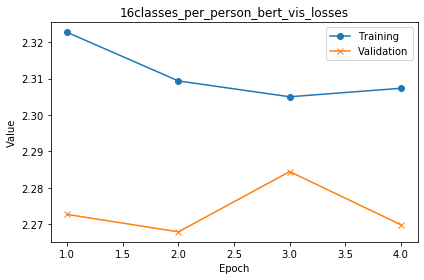

In [9]:
import matplotlib.pyplot as plt
plot_values(train_losses, val_losses, title=model_name+"_losses")

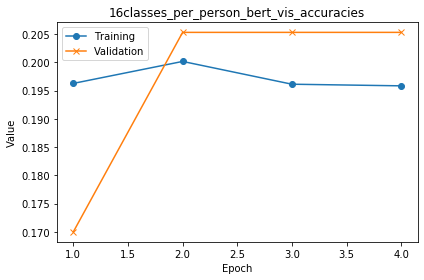

In [10]:
plot_values(train_accuracies, val_accuracies, title=model_name+"_accuracies")

In [11]:
layer0_val, layer0_ind = torch.topk(attentions[0][0,0,:,0], k=20) # attention[layer][batch,head,seq,seq]
print(layer0_val)
print(layer0_ind)
print([tokens[i] for i in layer0_ind])

tensor([0.0283, 0.0275, 0.0171, 0.0160, 0.0160, 0.0158, 0.0155, 0.0144, 0.0141,
        0.0133, 0.0129, 0.0124, 0.0124, 0.0118, 0.0104, 0.0100, 0.0096, 0.0083,
        0.0075, 0.0074], device='cuda:0')
tensor([397, 392, 396, 394, 389, 398, 409, 391, 390, 410, 406, 408, 407, 400,
        386, 404,   1, 403, 455, 324], device='cuda:0')
['to', 'your', 'it', 'are', 'unless', 'each', 'with', 'and', 'you', 'white', 'to', 'up', 'come', 'in', 'is', 'worth', 'your', 'not', 't', 'make']


In [12]:
layer1_val, layer1_ind = torch.topk(attentions[1][0,0,:,0], k=20)
print(layer1_val)
print(layer1_ind)
print([tokens[i] for i in layer1_ind])

tensor([0.5571, 0.4283, 0.3866, 0.3865, 0.3390, 0.3281, 0.3229, 0.3213, 0.3154,
        0.3117, 0.3110, 0.3107, 0.3040, 0.2904, 0.2825, 0.2809, 0.2763, 0.2722,
        0.2661, 0.2614], device='cuda:0')
tensor([492, 126, 478, 200, 175, 445,  98, 429, 486, 144, 473, 406, 409, 163,
        349, 124, 397, 312, 449, 259], device='cuda:0')
['considerably', 'excuse', '##fp', 'to', 'for', 'so', 'a', 'biggest', 'for', 'at', 'mb', 'to', 'with', 'with', 'yeah', 'a', 'to', 'with', 'with', 'a']


In [13]:
print([att[:, :, layer0_ind, :].shape for att in attentions])

[torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512]), torch.Size([1, 12, 20, 512])]


In [112]:
print([att[0, 0, layer0_ind] for att in attentions])  # attention weights "die" after layer 2...

[tensor([[0.0489, 0.0038, 0.0041,  ..., 0.0008, 0.0009, 0.0002],
        [0.0402, 0.0052, 0.0060,  ..., 0.0014, 0.0008, 0.0005],
        [0.0367, 0.0071, 0.0043,  ..., 0.0007, 0.0014, 0.0003],
        ...,
        [0.0143, 0.0047, 0.0041,  ..., 0.0012, 0.0013, 0.0008],
        [0.0136, 0.0049, 0.0053,  ..., 0.0017, 0.0009, 0.0015],
        [0.0135, 0.0059, 0.0026,  ..., 0.0007, 0.0008, 0.0007]],
       device='cuda:0'), tensor([[1.5111e-01, 1.0357e-03, 1.6847e-04,  ..., 6.9108e-04, 8.6620e-04,
         1.0670e-02],
        [2.0169e-02, 1.7506e-03, 1.9987e-04,  ..., 1.3543e-03, 2.1545e-03,
         1.2186e-02],
        [1.0231e-01, 1.1142e-03, 4.9077e-05,  ..., 1.5184e-03, 1.0365e-03,
         1.4920e-02],
        ...,
        [2.0714e-01, 1.8974e-03, 4.0292e-04,  ..., 4.1437e-04, 6.9306e-04,
         4.1138e-03],
        [2.5770e-02, 3.2411e-03, 7.9450e-04,  ..., 1.0893e-03, 2.9736e-03,
         3.2491e-03],
        [7.1882e-02, 2.3232e-04, 6.4724e-05,  ..., 3.2863e-04, 3.8928e-04,
   

In [ ]:
# head_view([att[:, :, :20, :20] for att in attentions], tokens[:20])  # first 20 tokens

In [14]:
head_view([att[:, :, torch.cat([torch.zeros(1, dtype=torch.long, device=device), layer1_ind]), :21] for att in attentions], ['[CLS]'] + [tokens[i] for i in layer1_ind])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>